# **Problem Statement**

The objective of the first half of the project is:
To build a Machine Learning Model to predict the payment date of an invoice 

*   To build a Machine Learning Model to predict the payment date of an invoice when it gets created in the system.
*   Categorize the invoice into different buckets based on predicted payment date.


First, we'll import the necessary libraries.

# **0. Installing Libraries and Modules**

In [ ]:
!pip install forex-python

     |████████████████████████████████| 133kB 8.0MB/s 
  Created wheel for forex-python: filename=forex_python-1.5-cp37-none-any.whl size=7235 sha256=1ebc8957958cb6aa6edb81dd53afbf9a8c5c52950578baf022ea6f92780a8826
  Stored in directory: /root/.cache/pip/wheels/c9/ee/ce/a0c208e72d186b786b0c51914675bc03d1bf00b8ed9406271b
Successfully built forex-python


In [ ]:
import numpy as np
import pandas as pd
from numpy import array, argmax
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# **1. Reading Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
load_data = pd.read_csv("/content/drive/MyDrive/dataset/1829126.csv")

In [ ]:
load_data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200865666,RESTAU corporation,2019-03-27 00:00:00,2019.0,1.928925e+09,2019-03-07,20190307,20190307,20190327.0,USD,RV,1.0,NaN,3831.32,20190307.0,NAD1,1.928925e+09,0
1,U001,0200707741,SMART & corporation,2019-05-24 00:00:00,2019.0,1.929291e+09,2019-05-10,20190510,20190510,20190525.0,USD,RV,1.0,NaN,60909.93,20190510.0,NAA8,1.929291e+09,0
2,U001,0200126819,MCLANE llc,2019-09-27 00:00:00,2019.0,1.929828e+09,2019-09-04,20190904,20190904,20190919.0,USD,RV,1.0,NaN,19606.32,20190904.0,NAA8,1.929828e+09,0
3,U001,0200762301,C&S WH foundation,2019-09-06 00:00:00,2019.0,1.929769e+09,2019-08-22,20190820,20190822,20190906.0,USD,RV,1.0,NaN,38474.45,20190822.0,NAC6,1.929769e+09,0
4,CA02,0140106408,WAL-M in,2019-01-31 00:00:00,2019.0,2.960523e+09,2019-01-15,20190115,20190115,20190125.0,CAD,RV,1.0,NaN,100360.78,20190115.0,CA10,2.960523e+09,0


In [ ]:
load_data.describe()

,buisness_year,doc_id,document_create_date,document_create_date.1,due_in_date,posting_id,area_business,total_open_amount,baseline_create_date,invoice_id,isOpen
count,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000.0,0.0,50000.000000,5.000000e+04,4.999200e+04,50000.000000
mean,2019.208940,2.013222e+09,2.019255e+07,2.019258e+07,2.019274e+07,1.0,NaN,32561.318156,2.019259e+07,2.012024e+09,0.088360
std,0.406556,2.935005e+08,3.948223e+03,3.935233e+03,3.943924e+03,0.0,NaN,39773.619844,3.936065e+03,2.778219e+08,0.283821
min,2019.000000,1.928499e+09,2.018123e+07,2.018123e+07,2.018123e+07,1.0,NaN,0.400000,2.018121e+07,1.928499e+09,0.000000
25%,2019.000000,1.929243e+09,2.019042e+07,2.019042e+07,2.019051e+07,1.0,NaN,4909.675000,2.019042e+07,1.929243e+09,0.000000
50%,2019.000000,1.929812e+09,2.019081e+07,2.019081e+07,2.019083e+07,1.0,NaN,17663.325000,2.019081e+07,1.929812e+09,0.000000
75%,2019.000000,1.930411e+09,2.019113e+07,2.019113e+07,2.019121e+07,1.0,NaN,47223.000000,2.019113e+07,1.930411e+09,0.000000
max,2020.000000,9.500000e+09,2.020052e+07,2.020052e+07,2.020070e+07,1.0,NaN,693159.200000,2.020052e+07,2.960634e+09,1.000000


# **2. Sanity Check/ Basic Preprocessing**

It is important to check if the data available to us is free of any errors, bad or useless data. We'll do a basic preprocessing of our dataset to ensure that.

In [ ]:
#check for missing values
load_data.isnull().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                 4418
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             50000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    8
isOpen                        0
dtype: int64

In [ ]:
#now sort according to document_create_date.1
load_data.sort_values('document_create_date.1',inplace=True)
load_data

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
31272,U001,CCCA02,KRAFT llc,2019-03-01 00:00:00,2019.0,1.928536e+09,2018-12-30,20181231,20181230,20190203.0,USD,RV,1.0,NaN,26562.50,20181230.0,NAG2,1.928536e+09,0
10711,U001,0200769623,WAL-MAR co,2019-01-18 00:00:00,2019.0,1.928535e+09,2018-12-30,20181229,20181230,20190114.0,USD,RV,1.0,NaN,12911.09,20181230.0,NAH4,1.928535e+09,0
35677,U001,0200769623,WAL-MAR corporation,2019-01-15 00:00:00,2019.0,1.928538e+09,2018-12-30,20181229,20181230,20190114.0,USD,RV,1.0,NaN,283.46,20181230.0,NAH4,1.928538e+09,0
29119,U001,0200726979,BJ'S associates,2019-01-22 00:00:00,2019.0,1.928537e+09,2018-12-30,20181229,20181230,20190114.0,USD,RV,1.0,NaN,59.80,20181230.0,NAA8,1.928537e+09,0
45494,U001,CCCA02,KRAFT co,2019-03-01 00:00:00,2019.0,1.928537e+09,2018-12-30,20181231,20181230,20190203.0,USD,RV,1.0,NaN,16663.80,20181230.0,NAG2,1.928537e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48512,CA02,0140104392,FLANAG llc,NaN,2020.0,2.960634e+09,2020-05-14,20200514,20200514,20200524.0,CAD,RV,1.0,NaN,7032.80,20200514.0,CA10,2.960634e+09,1
48813,U001,0200763229,MAINES associates,NaN,2020.0,1.930902e+09,2020-05-14,20200514,20200514,20200529.0,USD,RV,1.0,NaN,18639.45,20200514.0,NAA8,1.930902e+09,1
49203,U001,100030964,NATURA us,NaN,2020.0,1.930908e+09,2020-05-15,20200515,20200515,20200530.0,USD,RV,1.0,NaN,6692.21,20200515.0,NAA8,1.930908e+09,1
48830,U001,200956366,RICH systems,NaN,2020.0,1.930910e+09,2020-05-21,20200516,20200521,20200605.0,USD,RV,1.0,NaN,42360.00,20200521.0,NAA8,1.930910e+09,1


We'll convert the date columns to datetime dtype so they can be treated and handled as dates.

In [ ]:
#convert to datetime

load_data.loc[:,'clear_date']=pd.to_datetime(load_data.loc[:,'clear_date'])
load_data.loc[:,'posting_date']=pd.to_datetime(load_data.loc[:,'posting_date'])
load_data.loc[:,'document_create_date']=pd.to_datetime(load_data.loc[:,'document_create_date'],format="%Y%m%d")
load_data.loc[:,'document_create_date.1']=pd.to_datetime(load_data.loc[:,'document_create_date.1'],format="%Y%m%d")
load_data.loc[:,'due_in_date']=pd.to_datetime(load_data.loc[:,'due_in_date'],format="%Y%m%d")
load_data.loc[:,'baseline_create_date']=pd.to_datetime(load_data.loc[:,'baseline_create_date'],format="%Y%m%d")
load_data

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
31272,U001,CCCA02,KRAFT llc,2019-03-01,2019.0,1.928536e+09,2018-12-30,2018-12-31,2018-12-30,2019-02-03,USD,RV,1.0,NaN,26562.50,2018-12-30,NAG2,1.928536e+09,0
10711,U001,0200769623,WAL-MAR co,2019-01-18,2019.0,1.928535e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,USD,RV,1.0,NaN,12911.09,2018-12-30,NAH4,1.928535e+09,0
35677,U001,0200769623,WAL-MAR corporation,2019-01-15,2019.0,1.928538e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,USD,RV,1.0,NaN,283.46,2018-12-30,NAH4,1.928538e+09,0
29119,U001,0200726979,BJ'S associates,2019-01-22,2019.0,1.928537e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,USD,RV,1.0,NaN,59.80,2018-12-30,NAA8,1.928537e+09,0
45494,U001,CCCA02,KRAFT co,2019-03-01,2019.0,1.928537e+09,2018-12-30,2018-12-31,2018-12-30,2019-02-03,USD,RV,1.0,NaN,16663.80,2018-12-30,NAG2,1.928537e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48512,CA02,0140104392,FLANAG llc,NaT,2020.0,2.960634e+09,2020-05-14,2020-05-14,2020-05-14,2020-05-24,CAD,RV,1.0,NaN,7032.80,2020-05-14,CA10,2.960634e+09,1
48813,U001,0200763229,MAINES associates,NaT,2020.0,1.930902e+09,2020-05-14,2020-05-14,2020-05-14,2020-05-29,USD,RV,1.0,NaN,18639.45,2020-05-14,NAA8,1.930902e+09,1
49203,U001,100030964,NATURA us,NaT,2020.0,1.930908e+09,2020-05-15,2020-05-15,2020-05-15,2020-05-30,USD,RV,1.0,NaN,6692.21,2020-05-15,NAA8,1.930908e+09,1
48830,U001,200956366,RICH systems,NaT,2020.0,1.930910e+09,2020-05-21,2020-05-16,2020-05-21,2020-06-05,USD,RV,1.0,NaN,42360.00,2020-05-21,NAA8,1.930910e+09,1


The dates should be in the order doc_create_date1 <= posting date <= baselines date <= due date or clear date. We'll check for this condition and remove those anomalies which do not hold it true.

In [ ]:
#drop the rows with unusual conditions
load_data.drop(load_data[(load_data['posting_date'] - load_data['document_create_date.1']).dt.days < 0].index, inplace = True)
load_data.drop(load_data[(load_data['baseline_create_date'] - load_data['posting_date']).dt.days < 0].index, inplace = True)
load_data.drop(load_data[(load_data['due_in_date'] - load_data['baseline_create_date']).dt.days < 0].index, inplace = True)

load_data

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
31272,U001,CCCA02,KRAFT llc,2019-03-01,2019.0,1.928536e+09,2018-12-30,2018-12-31,2018-12-30,2019-02-03,USD,RV,1.0,NaN,26562.50,2018-12-30,NAG2,1.928536e+09,0
10711,U001,0200769623,WAL-MAR co,2019-01-18,2019.0,1.928535e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,USD,RV,1.0,NaN,12911.09,2018-12-30,NAH4,1.928535e+09,0
35677,U001,0200769623,WAL-MAR corporation,2019-01-15,2019.0,1.928538e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,USD,RV,1.0,NaN,283.46,2018-12-30,NAH4,1.928538e+09,0
29119,U001,0200726979,BJ'S associates,2019-01-22,2019.0,1.928537e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,USD,RV,1.0,NaN,59.80,2018-12-30,NAA8,1.928537e+09,0
45494,U001,CCCA02,KRAFT co,2019-03-01,2019.0,1.928537e+09,2018-12-30,2018-12-31,2018-12-30,2019-02-03,USD,RV,1.0,NaN,16663.80,2018-12-30,NAG2,1.928537e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48512,CA02,0140104392,FLANAG llc,NaT,2020.0,2.960634e+09,2020-05-14,2020-05-14,2020-05-14,2020-05-24,CAD,RV,1.0,NaN,7032.80,2020-05-14,CA10,2.960634e+09,1
48813,U001,0200763229,MAINES associates,NaT,2020.0,1.930902e+09,2020-05-14,2020-05-14,2020-05-14,2020-05-29,USD,RV,1.0,NaN,18639.45,2020-05-14,NAA8,1.930902e+09,1
49203,U001,100030964,NATURA us,NaT,2020.0,1.930908e+09,2020-05-15,2020-05-15,2020-05-15,2020-05-30,USD,RV,1.0,NaN,6692.21,2020-05-15,NAA8,1.930908e+09,1
48830,U001,200956366,RICH systems,NaT,2020.0,1.930910e+09,2020-05-21,2020-05-16,2020-05-21,2020-06-05,USD,RV,1.0,NaN,42360.00,2020-05-21,NAA8,1.930910e+09,1


In [ ]:
load_data.isnull().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                 4238
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             47789
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    0
isOpen                        0
dtype: int64

In [ ]:
#area_business is null for all values so we'll drop it.
load_data.drop(['area_business'], axis = 1, inplace = True)

## Encoding

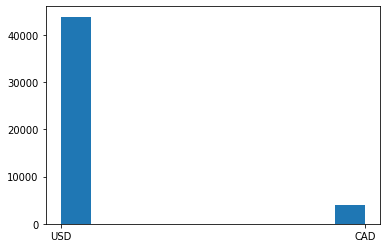

In [ ]:
to_plot = load_data.loc[:,'invoice_currency']
plt.hist(to_plot)
plt.show()

The amounts are in 2 different currencies, so we can convert the amount in CAD into USD according to the conversion rates as of their document create date.

In [ ]:
#Since currency is a nominal value, we should use one-hot encoding but for only 2 categories OHE is equivalent to label encoding so we can
#use that as well. Or, we can just convert amount column to a single common currency i.e. USD and drop the currency column.

from forex_python.converter import CurrencyRates
c = CurrencyRates()
for index, row in load_data.iterrows():
  if row['invoice_currency'] == 'CAD':
    load_data.loc[index, 'total_open_amount'] = round(row['total_open_amount']*c.get_rate('CAD', 'USD', pd.to_datetime(row['document_create_date.1'])))
load_data.drop(['invoice_currency'], axis = 1, inplace = True)

In [ ]:
load_data

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
31272,U001,CCCA02,KRAFT llc,2019-03-01,2019.0,1.928536e+09,2018-12-30,2018-12-31,2018-12-30,2019-02-03,RV,1.0,26562.50,2018-12-30,NAG2,1.928536e+09,0
10711,U001,0200769623,WAL-MAR co,2019-01-18,2019.0,1.928535e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,RV,1.0,12911.09,2018-12-30,NAH4,1.928535e+09,0
35677,U001,0200769623,WAL-MAR corporation,2019-01-15,2019.0,1.928538e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,RV,1.0,283.46,2018-12-30,NAH4,1.928538e+09,0
29119,U001,0200726979,BJ'S associates,2019-01-22,2019.0,1.928537e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,RV,1.0,59.80,2018-12-30,NAA8,1.928537e+09,0
45494,U001,CCCA02,KRAFT co,2019-03-01,2019.0,1.928537e+09,2018-12-30,2018-12-31,2018-12-30,2019-02-03,RV,1.0,16663.80,2018-12-30,NAG2,1.928537e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48512,CA02,0140104392,FLANAG llc,NaT,2020.0,2.960634e+09,2020-05-14,2020-05-14,2020-05-14,2020-05-24,RV,1.0,4985.00,2020-05-14,CA10,2.960634e+09,1
48813,U001,0200763229,MAINES associates,NaT,2020.0,1.930902e+09,2020-05-14,2020-05-14,2020-05-14,2020-05-29,RV,1.0,18639.45,2020-05-14,NAA8,1.930902e+09,1
49203,U001,100030964,NATURA us,NaT,2020.0,1.930908e+09,2020-05-15,2020-05-15,2020-05-15,2020-05-30,RV,1.0,6692.21,2020-05-15,NAA8,1.930908e+09,1
48830,U001,200956366,RICH systems,NaT,2020.0,1.930910e+09,2020-05-21,2020-05-16,2020-05-21,2020-06-05,RV,1.0,42360.00,2020-05-21,NAA8,1.930910e+09,1


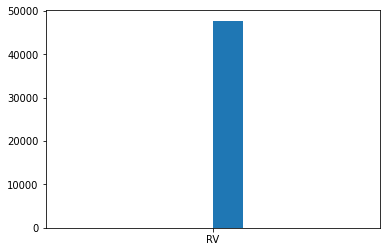

In [ ]:
to_plot = load_data.loc[:,'document type']
plt.hist(to_plot)
plt.show()

constant column.

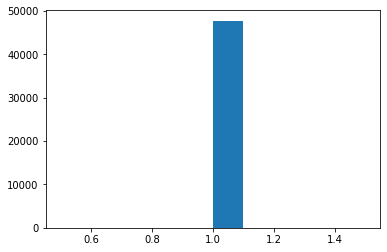

In [ ]:
to_plot = load_data.loc[:,'posting_id']
plt.hist(to_plot)
plt.show()

this one's constant as well

In [ ]:
load_data

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
31272,U001,CCCA02,KRAFT llc,2019-03-01,2019.0,1.928536e+09,2018-12-30,2018-12-31,2018-12-30,2019-02-03,RV,1.0,26562.50,2018-12-30,NAG2,1.928536e+09,0
10711,U001,0200769623,WAL-MAR co,2019-01-18,2019.0,1.928535e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,RV,1.0,12911.09,2018-12-30,NAH4,1.928535e+09,0
35677,U001,0200769623,WAL-MAR corporation,2019-01-15,2019.0,1.928538e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,RV,1.0,283.46,2018-12-30,NAH4,1.928538e+09,0
29119,U001,0200726979,BJ'S associates,2019-01-22,2019.0,1.928537e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,RV,1.0,59.80,2018-12-30,NAA8,1.928537e+09,0
45494,U001,CCCA02,KRAFT co,2019-03-01,2019.0,1.928537e+09,2018-12-30,2018-12-31,2018-12-30,2019-02-03,RV,1.0,16663.80,2018-12-30,NAG2,1.928537e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48512,CA02,0140104392,FLANAG llc,NaT,2020.0,2.960634e+09,2020-05-14,2020-05-14,2020-05-14,2020-05-24,RV,1.0,4985.00,2020-05-14,CA10,2.960634e+09,1
48813,U001,0200763229,MAINES associates,NaT,2020.0,1.930902e+09,2020-05-14,2020-05-14,2020-05-14,2020-05-29,RV,1.0,18639.45,2020-05-14,NAA8,1.930902e+09,1
49203,U001,100030964,NATURA us,NaT,2020.0,1.930908e+09,2020-05-15,2020-05-15,2020-05-15,2020-05-30,RV,1.0,6692.21,2020-05-15,NAA8,1.930908e+09,1
48830,U001,200956366,RICH systems,NaT,2020.0,1.930910e+09,2020-05-21,2020-05-16,2020-05-21,2020-06-05,RV,1.0,42360.00,2020-05-21,NAA8,1.930910e+09,1


drop the constant and id columns which won't help in prediction.

In [ ]:
load_data.drop(['isOpen'], axis = 1, inplace = True)
load_data.drop(['posting_id'], axis = 1, inplace = True)
load_data.drop(['document type'], axis = 1, inplace = True)
load_data.drop(['buisness_year'], axis = 1, inplace = True)
load_data.drop(['doc_id'], axis = 1, inplace = True)
load_data.drop(['invoice_id'], axis = 1, inplace = True)
load_data

,business_code,cust_number,name_customer,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms
31272,U001,CCCA02,KRAFT llc,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,26562.50,2018-12-30,NAG2
10711,U001,0200769623,WAL-MAR co,2019-01-18,2018-12-30,2018-12-29,2018-12-30,2019-01-14,12911.09,2018-12-30,NAH4
35677,U001,0200769623,WAL-MAR corporation,2019-01-15,2018-12-30,2018-12-29,2018-12-30,2019-01-14,283.46,2018-12-30,NAH4
29119,U001,0200726979,BJ'S associates,2019-01-22,2018-12-30,2018-12-29,2018-12-30,2019-01-14,59.80,2018-12-30,NAA8
45494,U001,CCCA02,KRAFT co,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,16663.80,2018-12-30,NAG2
...,...,...,...,...,...,...,...,...,...,...,...
48512,CA02,0140104392,FLANAG llc,NaT,2020-05-14,2020-05-14,2020-05-14,2020-05-24,4985.00,2020-05-14,CA10
48813,U001,0200763229,MAINES associates,NaT,2020-05-14,2020-05-14,2020-05-14,2020-05-29,18639.45,2020-05-14,NAA8
49203,U001,100030964,NATURA us,NaT,2020-05-15,2020-05-15,2020-05-15,2020-05-30,6692.21,2020-05-15,NAA8
48830,U001,200956366,RICH systems,NaT,2020-05-21,2020-05-16,2020-05-21,2020-06-05,42360.00,2020-05-21,NAA8


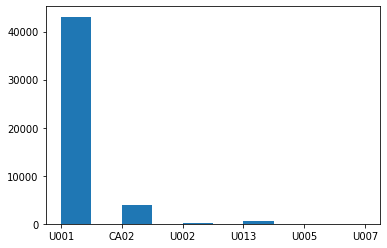

In [ ]:
to_plot = load_data.loc[:,'business_code']
plt.hist(to_plot)
plt.show()

it is present in several different categories, none of which show any order. So, we'll treat them as nominal category.

In [ ]:
#Since business code is a nominal category (does not follow any order), we use One-Hot Encoding

data_bc = load_data['business_code']
values_bc = array(data_bc)
#Label encode
label_encoder_bc = LabelEncoder()
integer_encoded_bc = label_encoder_bc.fit_transform(values_bc)
#binary encode
onehotencoder_bc = OneHotEncoder(sparse=False)
integer_encoded_bc = integer_encoded_bc.reshape(len(integer_encoded_bc), 1)
onehotencoded_bc = onehotencoder_bc.fit_transform(integer_encoded_bc)
load_data_bc = pd.DataFrame(onehotencoded_bc) #we will now convert the encoded sequence to dataframe to merge it to our dataframe
load_data_bc.columns = ['bc'+str(x) for x in range(load_data_bc.shape[1])] #naming the columns appropriately
load_data = pd.concat([load_data.reset_index(), load_data_bc.reset_index()], axis=1) #merging
load_data

,index,business_code,cust_number,name_customer,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,index,bc0,bc1,bc2,bc3,bc4,bc5
0,31272,U001,CCCA02,KRAFT llc,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,26562.50,2018-12-30,NAG2,0,0.0,1.0,0.0,0.0,0.0,0.0
1,10711,U001,0200769623,WAL-MAR co,2019-01-18,2018-12-30,2018-12-29,2018-12-30,2019-01-14,12911.09,2018-12-30,NAH4,1,0.0,1.0,0.0,0.0,0.0,0.0
2,35677,U001,0200769623,WAL-MAR corporation,2019-01-15,2018-12-30,2018-12-29,2018-12-30,2019-01-14,283.46,2018-12-30,NAH4,2,0.0,1.0,0.0,0.0,0.0,0.0
3,29119,U001,0200726979,BJ'S associates,2019-01-22,2018-12-30,2018-12-29,2018-12-30,2019-01-14,59.80,2018-12-30,NAA8,3,0.0,1.0,0.0,0.0,0.0,0.0
4,45494,U001,CCCA02,KRAFT co,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,16663.80,2018-12-30,NAG2,4,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47784,48512,CA02,0140104392,FLANAG llc,NaT,2020-05-14,2020-05-14,2020-05-14,2020-05-24,4985.00,2020-05-14,CA10,47784,1.0,0.0,0.0,0.0,0.0,0.0
47785,48813,U001,0200763229,MAINES associates,NaT,2020-05-14,2020-05-14,2020-05-14,2020-05-29,18639.45,2020-05-14,NAA8,47785,0.0,1.0,0.0,0.0,0.0,0.0
47786,49203,U001,100030964,NATURA us,NaT,2020-05-15,2020-05-15,2020-05-15,2020-05-30,6692.21,2020-05-15,NAA8,47786,0.0,1.0,0.0,0.0,0.0,0.0
47787,48830,U001,200956366,RICH systems,NaT,2020-05-21,2020-05-16,2020-05-21,2020-06-05,42360.00,2020-05-21,NAA8,47787,0.0,1.0,0.0,0.0,0.0,0.0


# **3. Train Test Validation Split**

*Now that we have got rid of all the useless and wrong information, we can go ahead with splitting the entire dataset into train, validation and test sets. We'll see later how they're important on their own.*

We can infer that for recent orders, clear_date is missing because they're still due or the data is not updated to their clearance date.
We'll use these rows for testing

In [ ]:
test_set = load_data[load_data['clear_date'].isnull()]
pred_test = test_set.copy()
test_set

,index,business_code,cust_number,name_customer,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,index,bc0,bc1,bc2,bc3,bc4,bc5
43545,48568,U001,0200769623,WAL-MAR foundation,NaT,2020-02-27,2020-02-27,2020-02-27,2020-03-13,36674.75,2020-02-27,NAH4,43545,0.0,1.0,0.0,0.0,0.0,0.0
43546,45793,U001,0200769623,WAL-MAR systems,NaT,2020-02-27,2020-02-27,2020-02-27,2020-03-13,59690.18,2020-02-27,NAH4,43546,0.0,1.0,0.0,0.0,0.0,0.0
43547,48533,U001,0200726979,BJ'S in,NaT,2020-02-27,2020-02-26,2020-02-27,2020-03-13,495.10,2020-02-27,NAA8,43547,0.0,1.0,0.0,0.0,0.0,0.0
43548,46668,U001,0200762950,HAR co,NaT,2020-02-27,2020-02-25,2020-02-27,2020-03-13,12631.96,2020-02-27,NAA8,43548,0.0,1.0,0.0,0.0,0.0,0.0
43549,46724,U001,0200769623,WAL-MAR llc,NaT,2020-02-27,2020-02-25,2020-02-27,2020-03-13,48398.25,2020-02-27,NAH4,43549,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47784,48512,CA02,0140104392,FLANAG llc,NaT,2020-05-14,2020-05-14,2020-05-14,2020-05-24,4985.00,2020-05-14,CA10,47784,1.0,0.0,0.0,0.0,0.0,0.0
47785,48813,U001,0200763229,MAINES associates,NaT,2020-05-14,2020-05-14,2020-05-14,2020-05-29,18639.45,2020-05-14,NAA8,47785,0.0,1.0,0.0,0.0,0.0,0.0
47786,49203,U001,100030964,NATURA us,NaT,2020-05-15,2020-05-15,2020-05-15,2020-05-30,6692.21,2020-05-15,NAA8,47786,0.0,1.0,0.0,0.0,0.0,0.0
47787,48830,U001,200956366,RICH systems,NaT,2020-05-21,2020-05-16,2020-05-21,2020-06-05,42360.00,2020-05-21,NAA8,47787,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
raw_train = load_data[load_data['clear_date'].notnull()]
raw_train

,index,business_code,cust_number,name_customer,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,index,bc0,bc1,bc2,bc3,bc4,bc5
0,31272,U001,CCCA02,KRAFT llc,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,26562.50,2018-12-30,NAG2,0,0.0,1.0,0.0,0.0,0.0,0.0
1,10711,U001,0200769623,WAL-MAR co,2019-01-18,2018-12-30,2018-12-29,2018-12-30,2019-01-14,12911.09,2018-12-30,NAH4,1,0.0,1.0,0.0,0.0,0.0,0.0
2,35677,U001,0200769623,WAL-MAR corporation,2019-01-15,2018-12-30,2018-12-29,2018-12-30,2019-01-14,283.46,2018-12-30,NAH4,2,0.0,1.0,0.0,0.0,0.0,0.0
3,29119,U001,0200726979,BJ'S associates,2019-01-22,2018-12-30,2018-12-29,2018-12-30,2019-01-14,59.80,2018-12-30,NAA8,3,0.0,1.0,0.0,0.0,0.0,0.0
4,45494,U001,CCCA02,KRAFT co,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,16663.80,2018-12-30,NAG2,4,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43594,36525,U001,0200794332,COST llc,2020-03-12,2020-02-27,2020-02-27,2020-02-27,2020-03-13,77997.49,2020-02-27,NAAX,43594,0.0,1.0,0.0,0.0,0.0,0.0
43596,7430,CA02,0140104392,FLANAG systems,2020-03-10,2020-02-27,2020-02-27,2020-02-27,2020-03-09,43599.00,2020-02-28,CA10,43596,1.0,0.0,0.0,0.0,0.0,0.0
43597,27580,U001,0200571849,US associates,2020-03-20,2020-02-27,2020-02-27,2020-02-27,2020-03-18,4230.72,2020-02-27,NAD1,43597,0.0,1.0,0.0,0.0,0.0,0.0
43598,26794,U001,0200794332,COST trust,2020-03-12,2020-02-27,2020-02-26,2020-02-27,2020-03-13,10990.81,2020-02-27,NAAX,43598,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
raw_train.dtypes

index                              int64
business_code                     object
cust_number                       object
name_customer                     object
clear_date                datetime64[ns]
posting_date              datetime64[ns]
document_create_date      datetime64[ns]
document_create_date.1    datetime64[ns]
due_in_date               datetime64[ns]
total_open_amount                float64
baseline_create_date      datetime64[ns]
cust_payment_terms                object
index                              int64
bc0                              float64
bc1                              float64
bc2                              float64
bc3                              float64
bc4                              float64
bc5                              float64
dtype: object

Before splitting it for train and validation, it is a good idea to check for any anomalies now itself so that we don't have to remove them individually from each set.

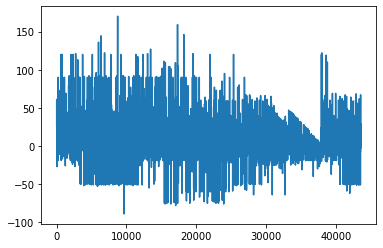

In [ ]:
A = (raw_train['clear_date'] - raw_train['due_in_date']).dt.days
A.plot()
plt.show()

there are very few instances of delay more than 150 days, so we should treat those as outliers and remove them.

In [ ]:
raw_train.drop(raw_train[(raw_train['clear_date'] - raw_train['due_in_date']).dt.days > 150].index, inplace = True)
test_set.drop(raw_train[(raw_train['clear_date'] - test_set['due_in_date']).dt.days > 150].index, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


After outlier removal,

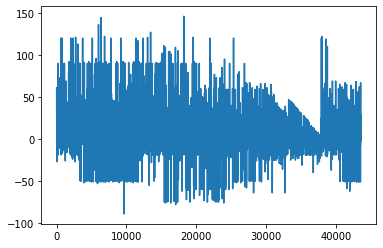

In [ ]:
A = (raw_train['clear_date'] - raw_train['due_in_date']).dt.days
A.plot()
plt.show()

Making target variable.


In [ ]:
raw_train['delay'] = (raw_train['clear_date'] - raw_train['due_in_date']).dt.days
y_raw = raw_train['delay']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


making validation set with the help of train_set_split method

In [ ]:
X_train, X_val, y_train, y_val = train_test_split (raw_train, y_raw, test_size = 0.3, shuffle=False)
X_val1, X_val2, y_val1, y_val2 = train_test_split (X_val, y_val, test_size = 0.5, shuffle=False)

In [ ]:
X_train

,index,business_code,cust_number,name_customer,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,index,bc0,bc1,bc2,bc3,bc4,bc5,delay
0,31272,U001,CCCA02,KRAFT llc,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,26562.50,2018-12-30,NAG2,0,0.0,1.0,0.0,0.0,0.0,0.0,26
1,10711,U001,0200769623,WAL-MAR co,2019-01-18,2018-12-30,2018-12-29,2018-12-30,2019-01-14,12911.09,2018-12-30,NAH4,1,0.0,1.0,0.0,0.0,0.0,0.0,4
2,35677,U001,0200769623,WAL-MAR corporation,2019-01-15,2018-12-30,2018-12-29,2018-12-30,2019-01-14,283.46,2018-12-30,NAH4,2,0.0,1.0,0.0,0.0,0.0,0.0,1
3,29119,U001,0200726979,BJ'S associates,2019-01-22,2018-12-30,2018-12-29,2018-12-30,2019-01-14,59.80,2018-12-30,NAA8,3,0.0,1.0,0.0,0.0,0.0,0.0,8
4,45494,U001,CCCA02,KRAFT co,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,16663.80,2018-12-30,NAG2,4,0.0,1.0,0.0,0.0,0.0,0.0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30481,38829,U001,0200769623,WAL-MAR,2019-10-18,2019-10-08,2019-10-07,2019-10-08,2019-10-23,2209.18,2019-10-08,NAH4,30481,0.0,1.0,0.0,0.0,0.0,0.0,-5
30482,33158,U001,0200769623,WAL-MAR llc,2019-10-18,2019-10-08,2019-10-06,2019-10-08,2019-10-23,15057.05,2019-10-08,NAH4,30482,0.0,1.0,0.0,0.0,0.0,0.0,-5
30483,38945,U001,0200783734,FAREW foundation,2019-11-15,2019-10-08,2019-10-07,2019-10-08,2019-11-17,3240.58,2019-10-08,NAWU,30483,0.0,1.0,0.0,0.0,0.0,0.0,-2
30484,27672,U001,0200769623,WAL-MAR in,2019-10-21,2019-10-08,2019-10-09,2019-10-08,2019-10-23,27739.72,2019-10-08,NAH4,30484,0.0,1.0,0.0,0.0,0.0,0.0,-2


In [ ]:
X_val1

,index,business_code,cust_number,name_customer,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,index,bc0,bc1,bc2,bc3,bc4,bc5,delay
30486,2313,U001,0200769623,WAL-MAR corporation,2019-10-18,2019-10-08,2019-10-04,2019-10-08,2019-10-23,16813.63,2019-10-08,NAH4,30486,0.0,1.0,0.0,0.0,0.0,0.0,-5
30487,25771,U001,CCU013,KRAFT F us,2019-11-27,2019-10-08,2019-10-06,2019-10-08,2019-10-08,19019.00,2019-10-08,NAX2,30487,0.0,1.0,0.0,0.0,0.0,0.0,50
30488,14167,CA02,0140104440,SO llc,2019-10-23,2019-10-08,2019-10-08,2019-10-08,2019-10-19,12559.00,2019-10-09,CA10,30488,1.0,0.0,0.0,0.0,0.0,0.0,4
30489,42029,U001,0200729828,KENNETH in,2019-10-29,2019-10-08,2019-10-03,2019-10-08,2019-10-28,24724.05,2019-10-08,NAD1,30489,0.0,1.0,0.0,0.0,0.0,0.0,1
30490,29565,U001,0200769623,WAL-MAR trust,2019-10-25,2019-10-08,2019-10-08,2019-10-08,2019-10-23,61898.18,2019-10-08,NAH4,30490,0.0,1.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37013,12255,U001,0200777735,NASH corporation,2019-12-23,2019-12-09,2019-12-09,2019-12-09,2019-12-24,118434.61,2019-12-09,NAA8,37013,0.0,1.0,0.0,0.0,0.0,0.0,-1
37014,18825,CA02,0140104249,SOB llc,2019-12-31,2019-12-09,2019-12-09,2019-12-09,2019-12-27,97028.00,2019-12-17,CA10,37014,1.0,0.0,0.0,0.0,0.0,0.0,4
37015,12682,U001,0200769623,WAL-MAR corporation,2019-12-20,2019-12-09,2019-12-08,2019-12-09,2019-12-24,29735.90,2019-12-09,NAH4,37015,0.0,1.0,0.0,0.0,0.0,0.0,-4
37016,40484,U001,0200769623,WAL-MAR in,2019-12-19,2019-12-09,2019-12-08,2019-12-09,2019-12-24,67244.93,2019-12-09,NAH4,37016,0.0,1.0,0.0,0.0,0.0,0.0,-5


In [ ]:
X_val2

,index,business_code,cust_number,name_customer,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,index,bc0,bc1,bc2,bc3,bc4,bc5,delay
37018,34847,U001,0200772670,ASSOCIAT in,2019-12-24,2019-12-09,2019-12-09,2019-12-09,2019-12-24,8373.86,2019-12-09,NAU5,37018,0.0,1.0,0.0,0.0,0.0,0.0,0
37019,22579,U001,0200762301,C&S WH associates,2019-12-24,2019-12-09,2019-12-08,2019-12-09,2019-12-24,24292.01,2019-12-09,NAC6,37019,0.0,1.0,0.0,0.0,0.0,0.0,0
37020,18593,U001,0200705742,DOT systems,2019-12-30,2019-12-09,2019-12-09,2019-12-09,2020-01-10,6781.18,2019-12-09,NA32,37020,0.0,1.0,0.0,0.0,0.0,0.0,-11
37021,8154,CA02,0140104409,LOB systems,2019-12-20,2019-12-09,2019-12-10,2019-12-09,2019-12-22,7127.00,2019-12-12,CA10,37021,1.0,0.0,0.0,0.0,0.0,0.0,-2
37022,35013,U001,0200646464,CUSTOMI associates,2019-12-24,2019-12-09,2019-12-06,2019-12-09,2019-12-24,23992.61,2019-12-09,NAA8,37022,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43594,36525,U001,0200794332,COST llc,2020-03-12,2020-02-27,2020-02-27,2020-02-27,2020-03-13,77997.49,2020-02-27,NAAX,43594,0.0,1.0,0.0,0.0,0.0,0.0,-1
43596,7430,CA02,0140104392,FLANAG systems,2020-03-10,2020-02-27,2020-02-27,2020-02-27,2020-03-09,43599.00,2020-02-28,CA10,43596,1.0,0.0,0.0,0.0,0.0,0.0,1
43597,27580,U001,0200571849,US associates,2020-03-20,2020-02-27,2020-02-27,2020-02-27,2020-03-18,4230.72,2020-02-27,NAD1,43597,0.0,1.0,0.0,0.0,0.0,0.0,2
43598,26794,U001,0200794332,COST trust,2020-03-12,2020-02-27,2020-02-26,2020-02-27,2020-03-13,10990.81,2020-02-27,NAAX,43598,0.0,1.0,0.0,0.0,0.0,0.0,-1


In [ ]:
y_train

0        26
1         4
2         1
3         8
4        26
         ..
30481    -5
30482    -5
30483    -2
30484    -2
30485     0
Name: delay, Length: 30484, dtype: int64

In [ ]:
y_val1

30486    -5
30487    50
30488     4
30489     1
30490     2
         ..
37013    -1
37014     4
37015    -4
37016    -5
37017     0
Name: delay, Length: 6532, dtype: int64

In [ ]:
y_val2

37018     0
37019     0
37020   -11
37021    -2
37022     0
         ..
43594    -1
43596     1
43597     2
43598    -1
43602     1
Name: delay, Length: 6533, dtype: int64

# **4. Exploratory Data Analysis**

*Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.*

In [ ]:
X_train

,index,business_code,cust_number,name_customer,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,index,bc0,bc1,bc2,bc3,bc4,bc5,delay
0,31272,U001,CCCA02,KRAFT llc,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,26562.50,2018-12-30,NAG2,0,0.0,1.0,0.0,0.0,0.0,0.0,26
1,10711,U001,0200769623,WAL-MAR co,2019-01-18,2018-12-30,2018-12-29,2018-12-30,2019-01-14,12911.09,2018-12-30,NAH4,1,0.0,1.0,0.0,0.0,0.0,0.0,4
2,35677,U001,0200769623,WAL-MAR corporation,2019-01-15,2018-12-30,2018-12-29,2018-12-30,2019-01-14,283.46,2018-12-30,NAH4,2,0.0,1.0,0.0,0.0,0.0,0.0,1
3,29119,U001,0200726979,BJ'S associates,2019-01-22,2018-12-30,2018-12-29,2018-12-30,2019-01-14,59.80,2018-12-30,NAA8,3,0.0,1.0,0.0,0.0,0.0,0.0,8
4,45494,U001,CCCA02,KRAFT co,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,16663.80,2018-12-30,NAG2,4,0.0,1.0,0.0,0.0,0.0,0.0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30481,38829,U001,0200769623,WAL-MAR,2019-10-18,2019-10-08,2019-10-07,2019-10-08,2019-10-23,2209.18,2019-10-08,NAH4,30481,0.0,1.0,0.0,0.0,0.0,0.0,-5
30482,33158,U001,0200769623,WAL-MAR llc,2019-10-18,2019-10-08,2019-10-06,2019-10-08,2019-10-23,15057.05,2019-10-08,NAH4,30482,0.0,1.0,0.0,0.0,0.0,0.0,-5
30483,38945,U001,0200783734,FAREW foundation,2019-11-15,2019-10-08,2019-10-07,2019-10-08,2019-11-17,3240.58,2019-10-08,NAWU,30483,0.0,1.0,0.0,0.0,0.0,0.0,-2
30484,27672,U001,0200769623,WAL-MAR in,2019-10-21,2019-10-08,2019-10-09,2019-10-08,2019-10-23,27739.72,2019-10-08,NAH4,30484,0.0,1.0,0.0,0.0,0.0,0.0,-2


Check for null values with the help of sns heatmap

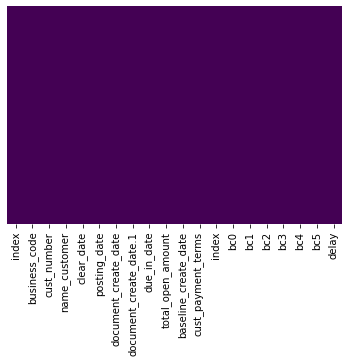

In [ ]:
sns.heatmap(X_train.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

Visualize amount column by sns displot

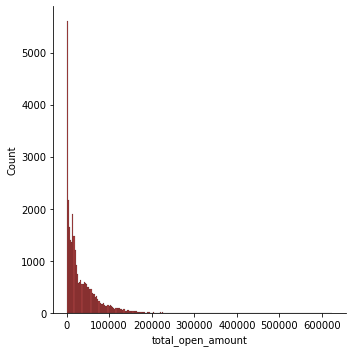

In [ ]:
sns.displot(X_train['total_open_amount'].dropna(),kde=False,color='darkred')

we can log transform that column for better visualization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


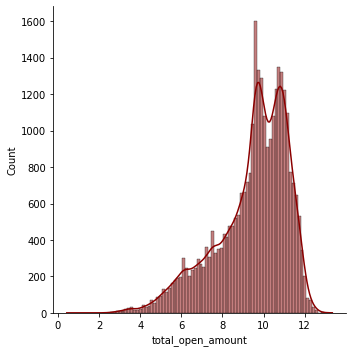

In [ ]:
X_train['total_open_amount'] = np.log1p(X_train['total_open_amount'])
sns.displot(X_train['total_open_amount'],kde=True,color='darkred')

The delay must have had some relation to the dates when amount was expected to be cleared and when it was actually cleared. We'll plot the delay with respect to all the date columns and visualize this for better intuition.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


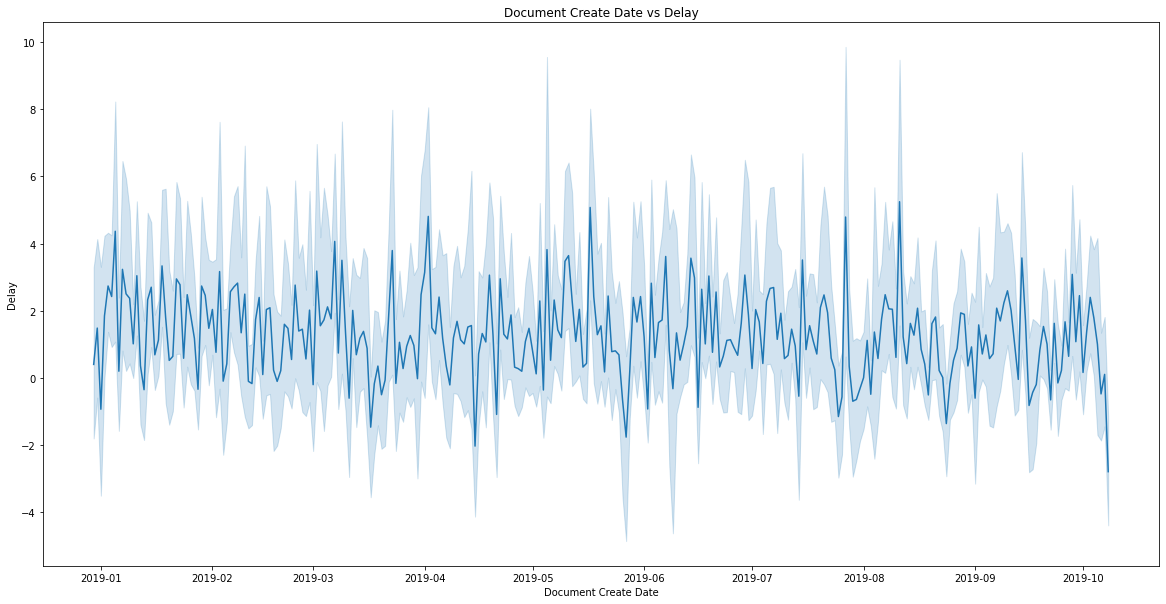

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(X_train['document_create_date.1'], X_train['delay'])
plt.xlabel("Document Create Date")
plt.ylabel("Delay")
plt.title("Document Create Date vs Delay")
plt.show()

pretty random spikes.. lets try with other date columns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


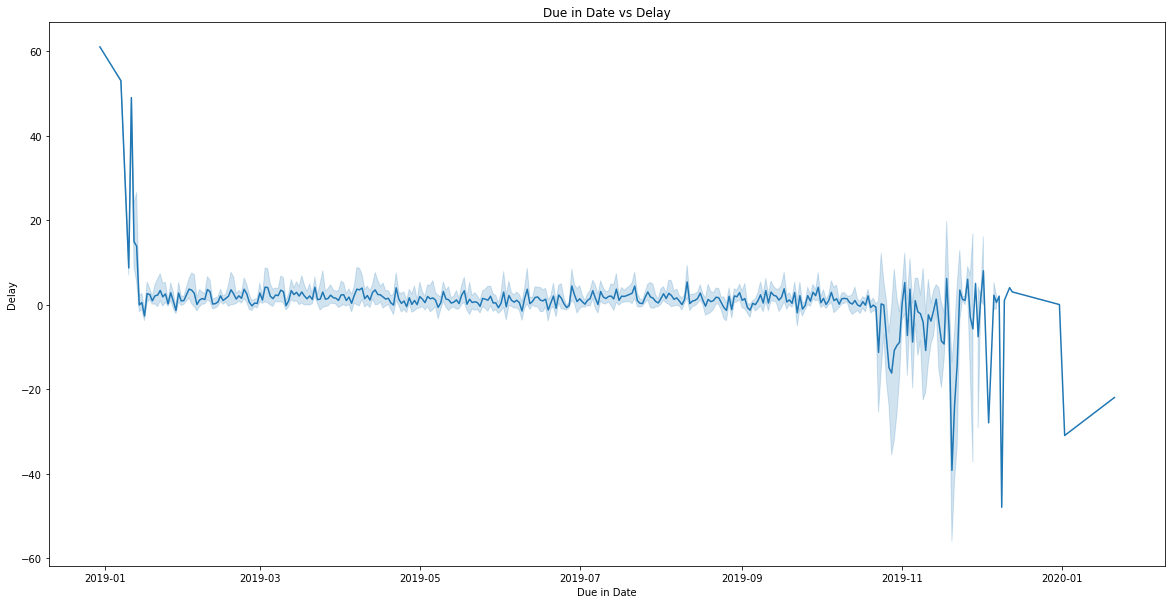

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(X_train['due_in_date'], X_train['delay'])
plt.xlabel("Due in Date")
plt.ylabel("Delay")
plt.title("Due in Date vs Delay")
plt.show()

This does not seem random at all. They delays are mostly 0 throughtout the year but they spike around the beginning and end of year.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


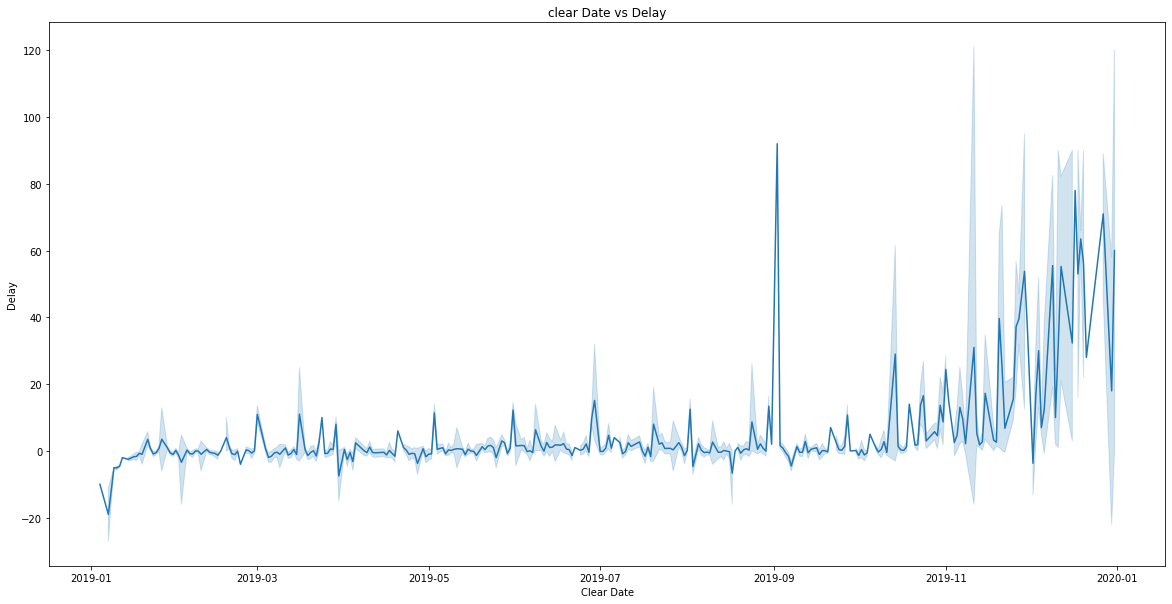

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(X_train['clear_date'], X_train['delay'])
plt.xlabel("Clear Date")
plt.ylabel("Delay")
plt.title("clear Date vs Delay")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


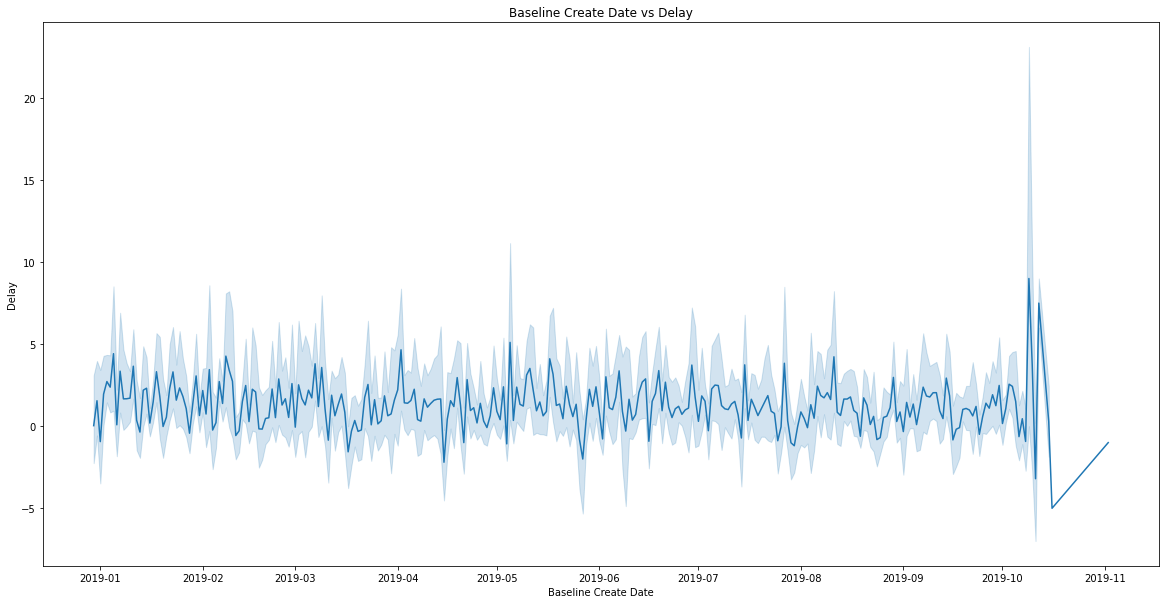

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(X_train['baseline_create_date'], X_train['delay'])
plt.xlabel("Baseline Create Date")
plt.ylabel("Delay")
plt.title("Baseline Create Date vs Delay")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


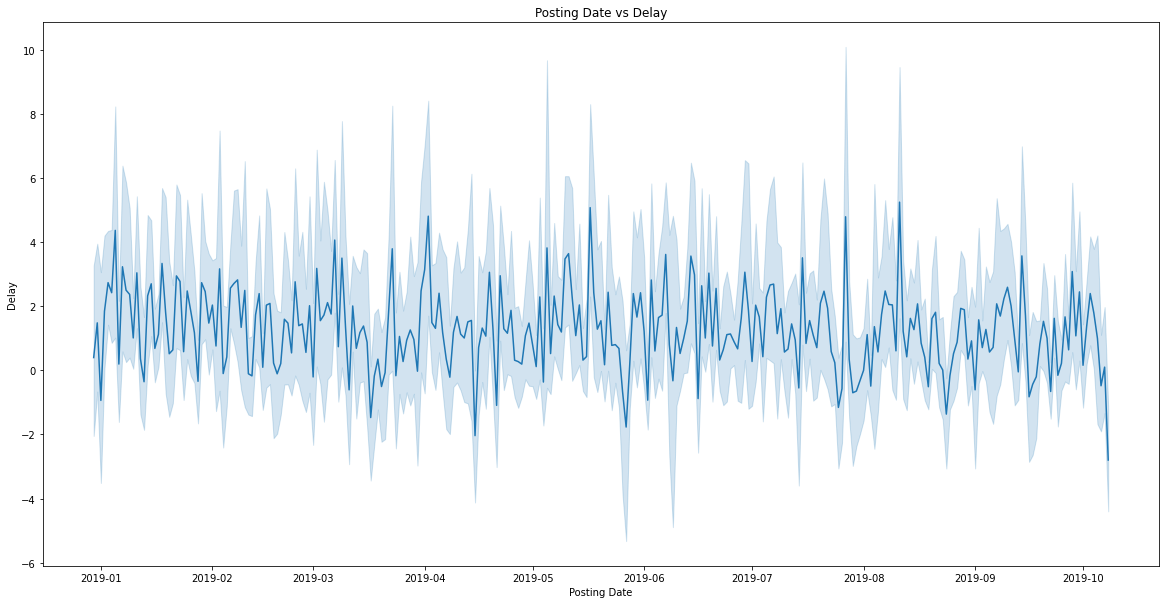

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(X_train['posting_date'], X_train['delay'])
plt.xlabel("Posting Date")
plt.ylabel("Delay")
plt.title("Posting Date vs Delay")
plt.show()

The rest of the graphs don't seem to provide any obvious relations.

Now, we'll check the correlation of features with target as well as among themselves with the help of Correlation heatmap.

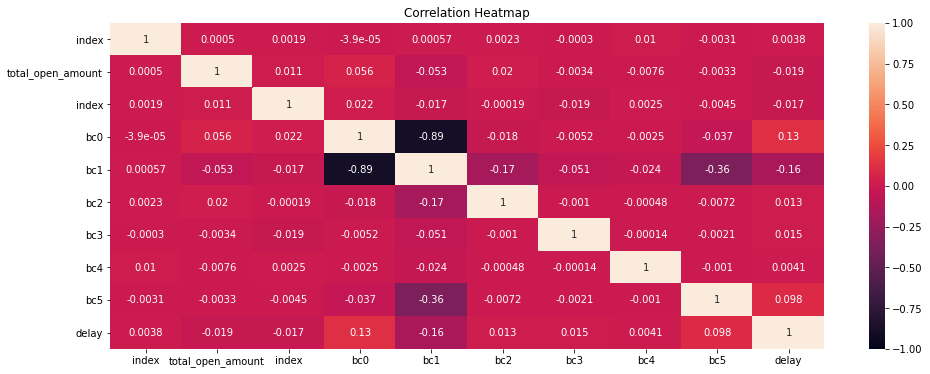

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

It shows that delay has very little correlation with other features. Not a great thing but we'll try this again after feature engineering with added features.

# **5. Feature Engineering**

*Feature engineering can be considered as applied machine learning itself. In FE, we use domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms.*

An important thing to infer is that every customer must have some common trends in their payment patterns. We can use that as a feature by putting their average delay against their name and use that as a feature showing that particular customer's "delay habit".

We'll map the mean customer delay with their name to all datasets.

In [ ]:
map_cust=X_train.groupby('name_customer')['delay'].mean().to_dict()

In [ ]:
map_cust

{'11078 llc': 7.0,
 '17135 corp': 4.0,
 '17135 in': -3.0,
 '17135 llc': 15.0,
 '17135 systems': 6.0,
 '236008 foundation': -4.0,
 '7 - E corp': -9.0,
 '7 - E trust': -12.0,
 '9043- llc': 23.0,
 '99 CE ': 1.0,
 '99 CE associates': 1.0,
 '99 CE co': 3.0,
 '99 CE corp': 1.0,
 '99 CE corporation': 4.0,
 '99 CE foundation': 1.0,
 '99 CE in': 2.0,
 '99 CE llc': 1.75,
 '99 CE systems': 2.0,
 '99 CE us': 1.0,
 'A & W F ': 4.0,
 'A & W F associates': 4.75,
 'A & W F co': -8.0,
 'A & W F corp': 8.0,
 'A & W F corporation': -5.0,
 'A & W F foundation': 0.6666666666666666,
 'A & W F in': -3.0,
 'A & W F llc': 4.0,
 'A & W F trust': 1.5,
 'A & W F us': -1.0,
 'ABC B trust': 5.0,
 'ACE  systems': -2.0,
 'ADAMS  corp': -1.0,
 'ADVAN corporation': -2.0,
 'AFFI ': -1.0,
 'AFFI associates': -1.0,
 'AFFI co': -5.0,
 'AFFI corp': -6.5,
 'AFFI llc': -5.0,
 'AFFI us': -11.0,
 'AFFILI ': -6.2,
 'AFFILI associates': -5.0,
 'AFFILI corp': -4.2,
 'AFFILI corporation': 0.6666666666666666,
 'AFFILI foundation': -

In [ ]:
X_train['Cust_Mean_Delay']=X_train['name_customer'].map(map_cust)
X_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,business_code,cust_number,name_customer,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,index,bc0,bc1,bc2,bc3,bc4,bc5,delay,Cust_Mean_Delay
0,31272,U001,CCCA02,KRAFT llc,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,10.187293,2018-12-30,NAG2,0,0.0,1.0,0.0,0.0,0.0,0.0,26,14.823529
1,10711,U001,0200769623,WAL-MAR co,2019-01-18,2018-12-30,2018-12-29,2018-12-30,2019-01-14,9.465919,2018-12-30,NAH4,1,0.0,1.0,0.0,0.0,0.0,0.0,4,-2.182081
2,35677,U001,0200769623,WAL-MAR corporation,2019-01-15,2018-12-30,2018-12-29,2018-12-30,2019-01-14,5.650593,2018-12-30,NAH4,2,0.0,1.0,0.0,0.0,0.0,0.0,1,-2.354985
3,29119,U001,0200726979,BJ'S associates,2019-01-22,2018-12-30,2018-12-29,2018-12-30,2019-01-14,4.107590,2018-12-30,NAA8,3,0.0,1.0,0.0,0.0,0.0,0.0,8,0.954955
4,45494,U001,CCCA02,KRAFT co,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,9.721054,2018-12-30,NAG2,4,0.0,1.0,0.0,0.0,0.0,0.0,26,12.488372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30481,38829,U001,0200769623,WAL-MAR,2019-10-18,2019-10-08,2019-10-07,2019-10-08,2019-10-23,7.700829,2019-10-08,NAH4,30481,0.0,1.0,0.0,0.0,0.0,0.0,-5,-1.861671
30482,33158,U001,0200769623,WAL-MAR llc,2019-10-18,2019-10-08,2019-10-06,2019-10-08,2019-10-23,9.619668,2019-10-08,NAH4,30482,0.0,1.0,0.0,0.0,0.0,0.0,-5,-2.360169
30483,38945,U001,0200783734,FAREW foundation,2019-11-15,2019-10-08,2019-10-07,2019-10-08,2019-11-17,8.083816,2019-10-08,NAWU,30483,0.0,1.0,0.0,0.0,0.0,0.0,-2,-1.333333
30484,27672,U001,0200769623,WAL-MAR in,2019-10-21,2019-10-08,2019-10-09,2019-10-08,2019-10-23,10.230657,2019-10-08,NAH4,30484,0.0,1.0,0.0,0.0,0.0,0.0,-2,-2.282303


In [ ]:
X_val1['Cust_Mean_Delay'] = X_val1['name_customer'].map(map_cust)
X_val1['Cust_Mean_Delay'][X_val1['Cust_Mean_Delay'].isnull()]= X_val1['delay'].mean()
X_val1['Cust_Mean_Delay'] = X_val1['Cust_Mean_Delay'].fillna(X_val1.groupby('name_customer')['delay'].transform('mean'))

X_val2['Cust_Mean_Delay']=X_val2['name_customer'].map(map_cust)
X_val2['Cust_Mean_Delay'][X_val2['Cust_Mean_Delay'].isnull()]= X_val2['delay'].mean()
X_val2['Cust_Mean_Delay'] = X_val2['Cust_Mean_Delay'].fillna(X_val2.groupby('name_customer')['delay'].transform('mean'))

test_set['Cust_Mean_Delay']=test_set['name_customer'].map(map_cust)
test_set['Cust_Mean_Delay'][test_set['Cust_Mean_Delay'].isnull()]= X_train['delay'].mean() #fill the 'null' new customer delay with mean delay of train_set
test_set['Cust_Mean_Delay'] = test_set['Cust_Mean_Delay'].fillna(X_train.groupby('name_customer')['delay'].transform('mean'))
test_set['Cust_Mean_Delay'] = test_set['Cust_Mean_Delay'].fillna(X_val1.groupby('name_customer')['delay'].transform('mean'))
test_set['Cust_Mean_Delay'] = test_set['Cust_Mean_Delay'].fillna(X_val2.groupby('name_customer')['delay'].transform('mean')) #fill the remaining 'null' values with mean delay of val and test sets.
test_set['Cust_Mean_Delay'].fillna(test_set['Cust_Mean_Delay'].mean(), inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [ ]:
X_val1.isnull().sum()

index                     0
business_code             0
cust_number               0
name_customer             0
clear_date                0
posting_date              0
document_create_date      0
document_create_date.1    0
due_in_date               0
total_open_amount         0
baseline_create_date      0
cust_payment_terms        0
index                     0
bc0                       0
bc1                       0
bc2                       0
bc3                       0
bc4                       0
bc5                       0
delay                     0
Cust_Mean_Delay           0
dtype: int64

In [ ]:
X_val2.isnull().sum()

index                     0
business_code             0
cust_number               0
name_customer             0
clear_date                0
posting_date              0
document_create_date      0
document_create_date.1    0
due_in_date               0
total_open_amount         0
baseline_create_date      0
cust_payment_terms        0
index                     0
bc0                       0
bc1                       0
bc2                       0
bc3                       0
bc4                       0
bc5                       0
delay                     0
Cust_Mean_Delay           0
dtype: int64

In [ ]:
#now we can drop names
X_train.drop(['name_customer'], axis = 1, inplace = True)
X_val1.drop(['name_customer'], axis = 1, inplace = True)
X_val2.drop(['name_customer'], axis = 1, inplace = True)
test_set.drop(['name_customer'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


There are several groups of customer numbers as well. So now we'll do the same thing for for customer number.

In [ ]:
map_cust1=X_train.groupby('cust_number')['delay'].mean().to_dict()
X_train['Custno_Mean_Delay']=X_train['cust_number'].map(map_cust1)

X_val1['Custno_Mean_Delay'] = X_val1['cust_number'].map(map_cust1)
X_val1['Custno_Mean_Delay'][X_val1['Custno_Mean_Delay'].isnull()]= X_val1['delay'].mean()
X_val1['Custno_Mean_Delay'] = X_val1['Custno_Mean_Delay'].fillna(X_val1.groupby('cust_number')['delay'].transform('mean'))

X_val2['Custno_Mean_Delay']=X_val2['cust_number'].map(map_cust1)
X_val2['Custno_Mean_Delay'][X_val2['Custno_Mean_Delay'].isnull()]= X_val2['delay'].mean()
X_val2['Custno_Mean_Delay'] = X_val2['Custno_Mean_Delay'].fillna(X_val2.groupby('cust_number')['delay'].transform('mean'))

test_set['Custno_Mean_Delay']=test_set['cust_number'].map(map_cust1)
test_set['Custno_Mean_Delay'][test_set['Custno_Mean_Delay'].isnull()]= X_train['delay'].mean()
test_set['Custno_Mean_Delay'] = test_set['Custno_Mean_Delay'].fillna(X_train.groupby('cust_number')['delay'].transform('mean'))
test_set['Custno_Mean_Delay'] = test_set['Custno_Mean_Delay'].fillna(X_val1.groupby('cust_number')['delay'].transform('mean'))
test_set['Custno_Mean_Delay'] = test_set['Custno_Mean_Delay'].fillna(X_val2.groupby('cust_number')['delay'].transform('mean'))
test_set['Custno_Mean_Delay'].fillna(test_set['Custno_Mean_Delay'].mean(), inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [ ]:
#Now we can drop customer number
X_train.drop(['cust_number'], axis = 1, inplace = True)
X_val1.drop(['cust_number'], axis = 1, inplace = True)
X_val2.drop(['cust_number'], axis = 1, inplace = True)
test_set.drop(['cust_number'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We'll do the same thing for Business Code and Customer Payment Terms.

In [ ]:
map_cust2=X_train.groupby('business_code')['delay'].mean().to_dict()
X_train['B_code_Mean_Delay']=X_train['business_code'].map(map_cust2)

X_val1['B_code_Mean_Delay'] = X_val1['business_code'].map(map_cust)
X_val1['B_code_Mean_Delay'][X_val1['B_code_Mean_Delay'].isnull()]= X_val1['delay'].mean()
X_val1['B_code_Mean_Delay'] = X_val1['B_code_Mean_Delay'].fillna(X_val1.groupby('business_code')['delay'].transform('mean'))

X_val2['B_code_Mean_Delay']=X_val2['business_code'].map(map_cust)
X_val2['B_code_Mean_Delay'][X_val2['B_code_Mean_Delay'].isnull()]= X_val2['delay'].mean()
X_val2['B_code_Mean_Delay'] = X_val2['B_code_Mean_Delay'].fillna(X_val2.groupby('business_code')['delay'].transform('mean'))

test_set['B_code_Mean_Delay']=test_set['business_code'].map(map_cust)
test_set['B_code_Mean_Delay'][test_set['B_code_Mean_Delay'].isnull()]= X_train['delay'].mean()
test_set['B_code_Mean_Delay'] = test_set['B_code_Mean_Delay'].fillna(X_train.groupby('business_code')['delay'].transform('mean'))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [ ]:
#Now we can drop business code
X_train.drop(['business_code'], axis = 1, inplace = True)
X_val1.drop(['business_code'], axis = 1, inplace = True)
X_val2.drop(['business_code'], axis = 1, inplace = True)
test_set.drop(['business_code'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
map_custterm=X_train.groupby('cust_payment_terms')['delay'].mean().to_dict()

In [ ]:
map_custterm

{'B052': -13.333333333333334,
 'B112': 2.3333333333333335,
 'BR12': 0.0,
 'BR56': 3.3333333333333335,
 'C106': -0.2777777777777778,
 'CA10': 6.358665058303177,
 'CA30': -6.785714285714286,
 'CA60': 2.0,
 'CAB1': 4.0,
 'NA10': 3.7071428571428573,
 'NA25': 0.0,
 'NA31': -6.0,
 'NA32': -3.5796812749003983,
 'NA38': 0.6875,
 'NA3B': -5.190476190476191,
 'NA3F': 3.5,
 'NA84': -4.6,
 'NA8Q': 14.25,
 'NA9X': -2.0,
 'NAA8': 1.250900266165649,
 'NAAW': -15.252032520325203,
 'NAAX': 0.2694938440492476,
 'NAB1': 4.111111111111111,
 'NABG': -1.25,
 'NAC6': 0.3870967741935484,
 'NACB': 5.043478260869565,
 'NAD1': 0.125193199381762,
 'NAD4': -0.5,
 'NAD5': 10.766949152542374,
 'NAD8': 1.0,
 'NAG2': 8.654281098546042,
 'NAGD': -10.440191387559809,
 'NAH4': -1.7411179822965928,
 'NANC': 3.0,
 'NATH': 1.0,
 'NATJ': 1.0,
 'NATK': 2.0,
 'NATL': 15.0,
 'NATM': 1.0,
 'NATU': 1.0,
 'NATV': 1.0,
 'NAU5': 1.3497536945812807,
 'NAUI': 108.5,
 'NAUP': 2.8,
 'NAUX': 60.0,
 'NAUZ': 1.0212765957446808,
 'NAV2': 78

In [ ]:
X_train['Term_Mean_Delay']=X_train['cust_payment_terms'].map(map_custterm)
X_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,index,bc0,bc1,bc2,bc3,bc4,bc5,delay,Cust_Mean_Delay,Custno_Mean_Delay,B_code_Mean_Delay,Term_Mean_Delay
0,31272,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,10.187293,2018-12-30,NAG2,0,0.0,1.0,0.0,0.0,0.0,0.0,26,14.823529,10.005249,0.660038,8.654281
1,10711,2019-01-18,2018-12-30,2018-12-29,2018-12-30,2019-01-14,9.465919,2018-12-30,NAH4,1,0.0,1.0,0.0,0.0,0.0,0.0,4,-2.182081,-2.081401,0.660038,-1.741118
2,35677,2019-01-15,2018-12-30,2018-12-29,2018-12-30,2019-01-14,5.650593,2018-12-30,NAH4,2,0.0,1.0,0.0,0.0,0.0,0.0,1,-2.354985,-2.081401,0.660038,-1.741118
3,29119,2019-01-22,2018-12-30,2018-12-29,2018-12-30,2019-01-14,4.107590,2018-12-30,NAA8,3,0.0,1.0,0.0,0.0,0.0,0.0,8,0.954955,0.953833,0.660038,1.250900
4,45494,2019-03-01,2018-12-30,2018-12-31,2018-12-30,2019-02-03,9.721054,2018-12-30,NAG2,4,0.0,1.0,0.0,0.0,0.0,0.0,26,12.488372,10.005249,0.660038,8.654281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30481,38829,2019-10-18,2019-10-08,2019-10-07,2019-10-08,2019-10-23,7.700829,2019-10-08,NAH4,30481,0.0,1.0,0.0,0.0,0.0,0.0,-5,-1.861671,-2.081401,0.660038,-1.741118
30482,33158,2019-10-18,2019-10-08,2019-10-06,2019-10-08,2019-10-23,9.619668,2019-10-08,NAH4,30482,0.0,1.0,0.0,0.0,0.0,0.0,-5,-2.360169,-2.081401,0.660038,-1.741118
30483,38945,2019-11-15,2019-10-08,2019-10-07,2019-10-08,2019-11-17,8.083816,2019-10-08,NAWU,30483,0.0,1.0,0.0,0.0,0.0,0.0,-2,-1.333333,-1.880000,0.660038,-5.305085
30484,27672,2019-10-21,2019-10-08,2019-10-09,2019-10-08,2019-10-23,10.230657,2019-10-08,NAH4,30484,0.0,1.0,0.0,0.0,0.0,0.0,-2,-2.282303,-2.081401,0.660038,-1.741118


In [ ]:
X_val1['Term_Mean_Delay'] = X_val1['cust_payment_terms'].map(map_custterm)
X_val1['Term_Mean_Delay'][X_val1['Term_Mean_Delay'].isnull()]= X_val1['delay'].mean()
X_val1['Term_Mean_Delay'] = X_val1['Term_Mean_Delay'].fillna(X_val1.groupby('cust_payment_terms')['delay'].transform('mean'))

X_val2['Term_Mean_Delay']=X_val2['cust_payment_terms'].map(map_custterm)
X_val2['Term_Mean_Delay'][X_val2['Term_Mean_Delay'].isnull()]= X_val2['delay'].mean()
X_val2['Term_Mean_Delay'] = X_val2['Term_Mean_Delay'].fillna(X_val2.groupby('cust_payment_terms')['delay'].transform('mean'))

test_set['Term_Mean_Delay']=test_set['cust_payment_terms'].map(map_custterm)
test_set['Term_Mean_Delay'][test_set['Term_Mean_Delay'].isnull()]= X_train['delay'].mean()
test_set['Term_Mean_Delay'] = test_set['Term_Mean_Delay'].fillna(X_train.groupby('cust_payment_terms')['delay'].transform('mean'))
test_set['Term_Mean_Delay'] = test_set['Term_Mean_Delay'].fillna(X_val1.groupby('cust_payment_terms')['delay'].transform('mean'))
test_set['Term_Mean_Delay'] = test_set['Term_Mean_Delay'].fillna(X_val2.groupby('cust_payment_terms')['delay'].transform('mean'))
test_set['Term_Mean_Delay'].fillna(test_set['Term_Mean_Delay'].mean(), inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [ ]:
#Now we can drop customer payment terms
X_train.drop(['cust_payment_terms'], axis = 1, inplace = True)
X_val1.drop(['cust_payment_terms'], axis = 1, inplace = True)
X_val2.drop(['cust_payment_terms'], axis = 1, inplace = True)
test_set.drop(['cust_payment_terms'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_val1.isnull().sum()

index                     0
clear_date                0
posting_date              0
document_create_date      0
document_create_date.1    0
due_in_date               0
total_open_amount         0
baseline_create_date      0
index                     0
bc0                       0
bc1                       0
bc2                       0
bc3                       0
bc4                       0
bc5                       0
delay                     0
Cust_Mean_Delay           0
Custno_Mean_Delay         0
B_code_Mean_Delay         0
Term_Mean_Delay           0
dtype: int64

In [ ]:
X_val2.isnull().sum()

index                     0
clear_date                0
posting_date              0
document_create_date      0
document_create_date.1    0
due_in_date               0
total_open_amount         0
baseline_create_date      0
index                     0
bc0                       0
bc1                       0
bc2                       0
bc3                       0
bc4                       0
bc5                       0
delay                     0
Cust_Mean_Delay           0
Custno_Mean_Delay         0
B_code_Mean_Delay         0
Term_Mean_Delay           0
dtype: int64

The dates are in datetime format, so we can't use them while modeling. We have to extract days, weekday, month year as integer values and use them as features.

In [ ]:
X_train['doc_day']=X_train['document_create_date.1'].dt.day
X_train['doc_month']=X_train['document_create_date.1'].dt.month
X_train['doc_year']=X_train['document_create_date.1'].dt.year
X_train['doc_weekday']=X_train['document_create_date.1'].dt.dayofweek
X_train['posting_day']=X_train['posting_date'].dt.day
X_train['posting_month']=X_train['posting_date'].dt.month
X_train['posting_year']=X_train['posting_date'].dt.year
X_train['posting_weekday']=X_train['posting_date'].dt.dayofweek
X_train['baseline_day']=X_train['baseline_create_date'].dt.day
X_train['baseline_month']=X_train['baseline_create_date'].dt.month
X_train['baseline_year']=X_train['baseline_create_date'].dt.year
X_train['baseline_weekday']=X_train['baseline_create_date'].dt.dayofweek
X_train['due_in_day']=X_train['due_in_date'].dt.day
X_train['due_month']=X_train['due_in_date'].dt.month
X_train['due_year']=X_train['due_in_date'].dt.year
X_train['due_weekday']=X_train['due_in_date'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
X_val1['doc_day']=X_val1['document_create_date.1'].dt.day
X_val1['doc_month']=X_val1['document_create_date.1'].dt.month
X_val1['doc_year']=X_val1['document_create_date.1'].dt.year
X_val1['doc_weekday']=X_val1['document_create_date.1'].dt.dayofweek
X_val1['posting_day']=X_val1['posting_date'].dt.day
X_val1['posting_month']=X_val1['posting_date'].dt.month
X_val1['posting_year']=X_val1['posting_date'].dt.year
X_val1['posting_weekday']=X_val1['posting_date'].dt.dayofweek
X_val1['baseline_day']=X_val1['baseline_create_date'].dt.day
X_val1['baseline_month']=X_val1['baseline_create_date'].dt.month
X_val1['baseline_year']=X_val1['baseline_create_date'].dt.year
X_val1['baseline_weekday']=X_val1['baseline_create_date'].dt.dayofweek
X_val1['due_in_day']=X_val1['due_in_date'].dt.day
X_val1['due_month']=X_val1['due_in_date'].dt.month
X_val1['due_year']=X_val1['due_in_date'].dt.year
X_val1['due_weekday']=X_val1['due_in_date'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
X_val2['doc_day']=X_val2['document_create_date.1'].dt.day
X_val2['doc_month']=X_val2['document_create_date.1'].dt.month
X_val2['doc_year']=X_val2['document_create_date.1'].dt.year
X_val2['doc_weekday']=X_val2['document_create_date.1'].dt.dayofweek
X_val2['posting_day']=X_val2['posting_date'].dt.day
X_val2['posting_month']=X_val2['posting_date'].dt.month
X_val2['posting_year']=X_val2['posting_date'].dt.year
X_val2['posting_weekday']=X_val2['posting_date'].dt.dayofweek
X_val2['baseline_day']=X_val2['baseline_create_date'].dt.day
X_val2['baseline_month']=X_val2['baseline_create_date'].dt.month
X_val2['baseline_year']=X_val2['baseline_create_date'].dt.year
X_val2['baseline_weekday']=X_val2['baseline_create_date'].dt.dayofweek
X_val2['due_in_day']=X_val2['due_in_date'].dt.day
X_val2['due_month']=X_val2['due_in_date'].dt.month
X_val2['due_year']=X_val2['due_in_date'].dt.year
X_val2['due_weekday']=X_val2['due_in_date'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
test_set['doc_day']=test_set['document_create_date.1'].dt.day
test_set['doc_month']=test_set['document_create_date.1'].dt.month
test_set['doc_year']=test_set['document_create_date.1'].dt.year
test_set['doc_weekday']=test_set['document_create_date.1'].dt.dayofweek
test_set['posting_day']=test_set['posting_date'].dt.day
test_set['posting_month']=test_set['posting_date'].dt.month
test_set['posting_year']=test_set['posting_date'].dt.year
test_set['posting_weekday']=test_set['posting_date'].dt.dayofweek
test_set['baseline_day']=test_set['baseline_create_date'].dt.day
test_set['baseline_month']=test_set['baseline_create_date'].dt.month
test_set['baseline_year']=test_set['baseline_create_date'].dt.year
test_set['baseline_weekday']=test_set['baseline_create_date'].dt.dayofweek
test_set['due_in_day']=test_set['due_in_date'].dt.day
test_set['due_month']=test_set['due_in_date'].dt.month
test_set['due_year']=test_set['due_in_date'].dt.year
test_set['due_weekday']=test_set['due_in_date'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
#So we can drop datetime columns
X_train.drop(['document_create_date', 'document_create_date.1', 'posting_date', 'due_in_date', 'clear_date', 'baseline_create_date'], axis = 1, inplace = True)
X_val1.drop(['document_create_date', 'document_create_date.1', 'posting_date', 'due_in_date', 'clear_date', 'baseline_create_date'], axis = 1, inplace = True)
X_val2.drop(['document_create_date', 'document_create_date.1', 'posting_date', 'due_in_date', 'clear_date', 'baseline_create_date'], axis = 1, inplace = True)
test_set.drop(['document_create_date', 'document_create_date.1', 'posting_date', 'due_in_date', 'clear_date', 'baseline_create_date'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_train

,index,total_open_amount,index,bc0,bc1,bc2,bc3,bc4,bc5,delay,Cust_Mean_Delay,Custno_Mean_Delay,B_code_Mean_Delay,Term_Mean_Delay,doc_day,doc_month,doc_year,doc_weekday,posting_day,posting_month,posting_year,posting_weekday,baseline_day,baseline_month,baseline_year,baseline_weekday,due_in_day,due_month,due_year,due_weekday
0,31272,10.187293,0,0.0,1.0,0.0,0.0,0.0,0.0,26,14.823529,10.005249,0.660038,8.654281,30,12,2018,6,30,12,2018,6,30,12,2018,6,3,2,2019,6
1,10711,9.465919,1,0.0,1.0,0.0,0.0,0.0,0.0,4,-2.182081,-2.081401,0.660038,-1.741118,30,12,2018,6,30,12,2018,6,30,12,2018,6,14,1,2019,0
2,35677,5.650593,2,0.0,1.0,0.0,0.0,0.0,0.0,1,-2.354985,-2.081401,0.660038,-1.741118,30,12,2018,6,30,12,2018,6,30,12,2018,6,14,1,2019,0
3,29119,4.107590,3,0.0,1.0,0.0,0.0,0.0,0.0,8,0.954955,0.953833,0.660038,1.250900,30,12,2018,6,30,12,2018,6,30,12,2018,6,14,1,2019,0
4,45494,9.721054,4,0.0,1.0,0.0,0.0,0.0,0.0,26,12.488372,10.005249,0.660038,8.654281,30,12,2018,6,30,12,2018,6,30,12,2018,6,3,2,2019,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30481,38829,7.700829,30481,0.0,1.0,0.0,0.0,0.0,0.0,-5,-1.861671,-2.081401,0.660038,-1.741118,8,10,2019,1,8,10,2019,1,8,10,2019,1,23,10,2019,2
30482,33158,9.619668,30482,0.0,1.0,0.0,0.0,0.0,0.0,-5,-2.360169,-2.081401,0.660038,-1.741118,8,10,2019,1,8,10,2019,1,8,10,2019,1,23,10,2019,2
30483,38945,8.083816,30483,0.0,1.0,0.0,0.0,0.0,0.0,-2,-1.333333,-1.880000,0.660038,-5.305085,8,10,2019,1,8,10,2019,1,8,10,2019,1,17,11,2019,6
30484,27672,10.230657,30484,0.0,1.0,0.0,0.0,0.0,0.0,-2,-2.282303,-2.081401,0.660038,-1.741118,8,10,2019,1,8,10,2019,1,8,10,2019,1,23,10,2019,2


In [ ]:
X_val1

,index,total_open_amount,index,bc0,bc1,bc2,bc3,bc4,bc5,delay,Cust_Mean_Delay,Custno_Mean_Delay,B_code_Mean_Delay,Term_Mean_Delay,doc_day,doc_month,doc_year,doc_weekday,posting_day,posting_month,posting_year,posting_weekday,baseline_day,baseline_month,baseline_year,baseline_weekday,due_in_day,due_month,due_year,due_weekday
30486,2313,16813.63,30486,0.0,1.0,0.0,0.0,0.0,0.0,-5,-2.354985,-2.081401,0.220410,-1.741118,8,10,2019,1,8,10,2019,1,8,10,2019,1,23,10,2019,2
30487,25771,19019.00,30487,0.0,1.0,0.0,0.0,0.0,0.0,50,46.704545,44.344749,0.220410,44.995485,8,10,2019,1,8,10,2019,1,8,10,2019,1,8,10,2019,1
30488,14167,12559.00,30488,1.0,0.0,0.0,0.0,0.0,0.0,4,6.250000,6.012121,3.803536,6.358665,8,10,2019,1,8,10,2019,1,9,10,2019,2,19,10,2019,5
30489,42029,24724.05,30489,0.0,1.0,0.0,0.0,0.0,0.0,1,1.000000,3.111111,0.220410,0.125193,8,10,2019,1,8,10,2019,1,8,10,2019,1,28,10,2019,0
30490,29565,61898.18,30490,0.0,1.0,0.0,0.0,0.0,0.0,2,-1.902362,-2.081401,0.220410,-1.741118,8,10,2019,1,8,10,2019,1,8,10,2019,1,23,10,2019,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37013,12255,118434.61,37013,0.0,1.0,0.0,0.0,0.0,0.0,-1,-5.833333,-6.528926,0.220410,1.250900,9,12,2019,0,9,12,2019,0,9,12,2019,0,24,12,2019,1
37014,18825,97028.00,37014,1.0,0.0,0.0,0.0,0.0,0.0,4,4.500000,4.927273,3.803536,6.358665,9,12,2019,0,9,12,2019,0,17,12,2019,1,27,12,2019,4
37015,12682,29735.90,37015,0.0,1.0,0.0,0.0,0.0,0.0,-4,-2.354985,-2.081401,0.220410,-1.741118,9,12,2019,0,9,12,2019,0,9,12,2019,0,24,12,2019,1
37016,40484,67244.93,37016,0.0,1.0,0.0,0.0,0.0,0.0,-5,-2.282303,-2.081401,0.220410,-1.741118,9,12,2019,0,9,12,2019,0,9,12,2019,0,24,12,2019,1


In [ ]:
X_val2

,index,total_open_amount,index,bc0,bc1,bc2,bc3,bc4,bc5,delay,Cust_Mean_Delay,Custno_Mean_Delay,B_code_Mean_Delay,Term_Mean_Delay,doc_day,doc_month,doc_year,doc_weekday,posting_day,posting_month,posting_year,posting_weekday,baseline_day,baseline_month,baseline_year,baseline_weekday,due_in_day,due_month,due_year,due_weekday
37018,34847,8373.86,37018,0.0,1.0,0.0,0.0,0.0,0.0,0,1.840580,1.411074,-0.031709,1.349754,9,12,2019,0,9,12,2019,0,9,12,2019,0,24,12,2019,1
37019,22579,24292.01,37019,0.0,1.0,0.0,0.0,0.0,0.0,0,-0.292135,0.095781,-0.031709,0.387097,9,12,2019,0,9,12,2019,0,9,12,2019,0,24,12,2019,1
37020,18593,6781.18,37020,0.0,1.0,0.0,0.0,0.0,0.0,-11,-6.648148,-6.544355,-0.031709,-3.579681,9,12,2019,0,9,12,2019,0,9,12,2019,0,10,1,2020,4
37021,8154,7127.00,37021,1.0,0.0,0.0,0.0,0.0,0.0,-2,2.346154,1.720779,6.239006,6.358665,9,12,2019,0,9,12,2019,0,12,12,2019,3,22,12,2019,6
37022,35013,23992.61,37022,0.0,1.0,0.0,0.0,0.0,0.0,0,0.000000,0.600000,-0.031709,1.250900,9,12,2019,0,9,12,2019,0,9,12,2019,0,24,12,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43594,36525,77997.49,43594,0.0,1.0,0.0,0.0,0.0,0.0,-1,0.131579,-0.036697,-0.031709,0.269494,27,2,2020,3,27,2,2020,3,27,2,2020,3,13,3,2020,4
43596,7430,43599.00,43596,1.0,0.0,0.0,0.0,0.0,0.0,1,1.000000,14.000000,6.239006,6.358665,27,2,2020,3,27,2,2020,3,28,2,2020,4,9,3,2020,0
43597,27580,4230.72,43597,0.0,1.0,0.0,0.0,0.0,0.0,2,2.365854,1.666667,-0.031709,0.125193,27,2,2020,3,27,2,2020,3,27,2,2020,3,18,3,2020,2
43598,26794,10990.81,43598,0.0,1.0,0.0,0.0,0.0,0.0,-1,-0.396825,-0.036697,-0.031709,0.269494,27,2,2020,3,27,2,2020,3,27,2,2020,3,13,3,2020,4


In [ ]:
test_set

,index,total_open_amount,index,bc0,bc1,bc2,bc3,bc4,bc5,Cust_Mean_Delay,Custno_Mean_Delay,B_code_Mean_Delay,Term_Mean_Delay,doc_day,doc_month,doc_year,doc_weekday,posting_day,posting_month,posting_year,posting_weekday,baseline_day,baseline_month,baseline_year,baseline_weekday,due_in_day,due_month,due_year,due_weekday
43545,48568,36674.75,43545,0.0,1.0,0.0,0.0,0.0,0.0,-1.749284,-2.081401,NaN,-1.741118,27,2,2020,3,27,2,2020,3,27,2,2020,3,13,3,2020,4
43546,45793,59690.18,43546,0.0,1.0,0.0,0.0,0.0,0.0,-1.385779,-2.081401,NaN,-1.741118,27,2,2020,3,27,2,2020,3,27,2,2020,3,13,3,2020,4
43547,48533,495.10,43547,0.0,1.0,0.0,0.0,0.0,0.0,1.078261,0.953833,NaN,1.250900,27,2,2020,3,27,2,2020,3,27,2,2020,3,13,3,2020,4
43548,46668,12631.96,43548,0.0,1.0,0.0,0.0,0.0,0.0,-0.333333,1.350877,NaN,1.250900,27,2,2020,3,27,2,2020,3,27,2,2020,3,13,3,2020,4
43549,46724,48398.25,43549,0.0,1.0,0.0,0.0,0.0,0.0,-2.360169,-2.081401,NaN,-1.741118,27,2,2020,3,27,2,2020,3,27,2,2020,3,13,3,2020,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47784,48512,4985.00,47784,1.0,0.0,0.0,0.0,0.0,0.0,120.000000,14.000000,NaN,6.358665,14,5,2020,3,14,5,2020,3,14,5,2020,3,24,5,2020,6
47785,48813,18639.45,47785,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.350000,NaN,1.250900,14,5,2020,3,14,5,2020,3,14,5,2020,3,29,5,2020,4
47786,49203,6692.21,47786,0.0,1.0,0.0,0.0,0.0,0.0,-6.000000,-1.333333,NaN,1.250900,15,5,2020,4,15,5,2020,4,15,5,2020,4,30,5,2020,5
47787,48830,42360.00,47787,0.0,1.0,0.0,0.0,0.0,0.0,-1.000000,0.000000,NaN,1.250900,21,5,2020,3,21,5,2020,3,21,5,2020,3,5,6,2020,4


# **5. Feature Selection**

*Here, we'll try some techniques that will automatically or manually select those features which contribute most to our prediction variable or output in which we are interested in. Having irrelevant features in our data can decrease the accuracy of the models and make the model learn based on irrelevant features.*

We'll draw a correlation heatmap to check the correlation of features with the target column as well as their inter_correlation. The features that have very little correlation with target are mostly irrelevant (although correlation does not mean causation so we have to be careful). Also, if one feature is highly correlated to another feature then having them both is redundant. So, out of those two, we'll drop the one which has less correlation with target variable.

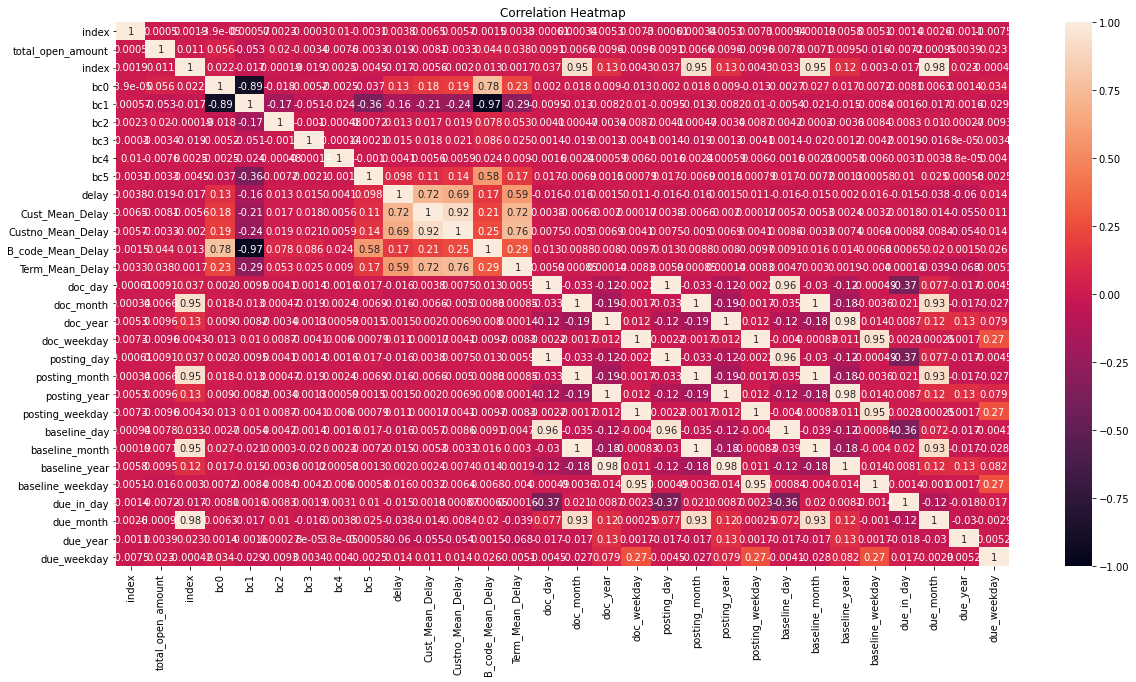

In [ ]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

In [ ]:
#Correlation with output variable
cor_target = abs(X_train.corr()['delay'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

delay                1.000000
Cust_Mean_Delay      0.723945
Custno_Mean_Delay    0.686182
Term_Mean_Delay      0.586350
Name: delay, dtype: float64

So, it shows that Cust_Mean_Delay and Custno_Mean_Delay have high correlation with delay.

We'll remove less important feature from 2 correlated features by filter method.

In [ ]:
correlated_features = set()
correlation_matrix = X_train.corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8: #features which are more than 80% inter-correlated.
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_train.drop(labels=correlated_features, axis=1, inplace=True) #drop correlated features from all sets
X_val1.drop(labels=correlated_features, axis=1, inplace=True)
X_val2.drop(labels=correlated_features, axis=1, inplace=True)
test_set.drop(labels=correlated_features, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_train

,index,total_open_amount,index,bc0,bc2,bc3,bc4,bc5,delay,Cust_Mean_Delay,Term_Mean_Delay,doc_day,doc_year,doc_weekday,due_in_day,due_year,due_weekday
0,31272,10.187293,0,0.0,0.0,0.0,0.0,0.0,26,14.823529,8.654281,30,2018,6,3,2019,6
1,10711,9.465919,1,0.0,0.0,0.0,0.0,0.0,4,-2.182081,-1.741118,30,2018,6,14,2019,0
2,35677,5.650593,2,0.0,0.0,0.0,0.0,0.0,1,-2.354985,-1.741118,30,2018,6,14,2019,0
3,29119,4.107590,3,0.0,0.0,0.0,0.0,0.0,8,0.954955,1.250900,30,2018,6,14,2019,0
4,45494,9.721054,4,0.0,0.0,0.0,0.0,0.0,26,12.488372,8.654281,30,2018,6,3,2019,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30481,38829,7.700829,30481,0.0,0.0,0.0,0.0,0.0,-5,-1.861671,-1.741118,8,2019,1,23,2019,2
30482,33158,9.619668,30482,0.0,0.0,0.0,0.0,0.0,-5,-2.360169,-1.741118,8,2019,1,23,2019,2
30483,38945,8.083816,30483,0.0,0.0,0.0,0.0,0.0,-2,-1.333333,-5.305085,8,2019,1,17,2019,6
30484,27672,10.230657,30484,0.0,0.0,0.0,0.0,0.0,-2,-2.282303,-1.741118,8,2019,1,23,2019,2


In [ ]:
test_set

,index,total_open_amount,index,bc0,bc2,bc3,bc4,bc5,Cust_Mean_Delay,Term_Mean_Delay,doc_day,doc_year,doc_weekday,due_in_day,due_year,due_weekday
43545,48568,36674.75,43545,0.0,0.0,0.0,0.0,0.0,-1.749284,-1.741118,27,2020,3,13,2020,4
43546,45793,59690.18,43546,0.0,0.0,0.0,0.0,0.0,-1.385779,-1.741118,27,2020,3,13,2020,4
43547,48533,495.10,43547,0.0,0.0,0.0,0.0,0.0,1.078261,1.250900,27,2020,3,13,2020,4
43548,46668,12631.96,43548,0.0,0.0,0.0,0.0,0.0,-0.333333,1.250900,27,2020,3,13,2020,4
43549,46724,48398.25,43549,0.0,0.0,0.0,0.0,0.0,-2.360169,-1.741118,27,2020,3,13,2020,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47784,48512,4985.00,47784,1.0,0.0,0.0,0.0,0.0,120.000000,6.358665,14,2020,3,24,2020,6
47785,48813,18639.45,47785,0.0,0.0,0.0,0.0,0.0,0.666667,1.250900,14,2020,3,29,2020,4
47786,49203,6692.21,47786,0.0,0.0,0.0,0.0,0.0,-6.000000,1.250900,15,2020,4,30,2020,5
47787,48830,42360.00,47787,0.0,0.0,0.0,0.0,0.0,-1.000000,1.250900,21,2020,3,5,2020,4


Now, we must drop target column from training and validation X sets.

In [ ]:
X_train.drop(['delay'], axis = 1, inplace=True)
X_val1.drop(['delay'], axis = 1, inplace=True)
X_val2.drop(['delay'], axis = 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_train.drop(['index'], axis = 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We'll perform p-value backward elimination wrapper technique for further feature selection.

In [ ]:
#Backward Elimination
import statsmodels.api as sm
cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    if 'index' in X_1.columns:
      X_1.drop(['index'], axis = 1, inplace=True)
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.5):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
selected_features_BE

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['total_open_amount',
 'bc0',
 'bc2',
 'bc5',
 'Cust_Mean_Delay',
 'Term_Mean_Delay',
 'doc_day',
 'doc_weekday',
 'due_in_day',
 'due_year',
 'due_weekday']

and keep only those columns that are selected by backward elimination.

In [ ]:
X_train = X_train[X_train.columns.intersection(selected_features_BE)]
X_val1 = X_val1[X_val1.columns.intersection(selected_features_BE)]
X_val2 = X_val2[X_val2.columns.intersection(selected_features_BE)]
test_set = test_set[test_set.columns.intersection(selected_features_BE)]

In [ ]:
X_train

,total_open_amount,bc0,bc2,bc5,Cust_Mean_Delay,Term_Mean_Delay,doc_day,doc_weekday,due_in_day,due_year,due_weekday
0,10.187293,0.0,0.0,0.0,14.823529,8.654281,30,6,3,2019,6
1,9.465919,0.0,0.0,0.0,-2.182081,-1.741118,30,6,14,2019,0
2,5.650593,0.0,0.0,0.0,-2.354985,-1.741118,30,6,14,2019,0
3,4.107590,0.0,0.0,0.0,0.954955,1.250900,30,6,14,2019,0
4,9.721054,0.0,0.0,0.0,12.488372,8.654281,30,6,3,2019,6
...,...,...,...,...,...,...,...,...,...,...,...
30481,7.700829,0.0,0.0,0.0,-1.861671,-1.741118,8,1,23,2019,2
30482,9.619668,0.0,0.0,0.0,-2.360169,-1.741118,8,1,23,2019,2
30483,8.083816,0.0,0.0,0.0,-1.333333,-5.305085,8,1,17,2019,6
30484,10.230657,0.0,0.0,0.0,-2.282303,-1.741118,8,1,23,2019,2


In [ ]:
X_val1

,total_open_amount,bc0,bc2,bc5,Cust_Mean_Delay,Term_Mean_Delay,doc_day,doc_weekday,due_in_day,due_year,due_weekday
30486,16813.63,0.0,0.0,0.0,-2.354985,-1.741118,8,1,23,2019,2
30487,19019.00,0.0,0.0,0.0,46.704545,44.995485,8,1,8,2019,1
30488,12559.00,1.0,0.0,0.0,6.250000,6.358665,8,1,19,2019,5
30489,24724.05,0.0,0.0,0.0,1.000000,0.125193,8,1,28,2019,0
30490,61898.18,0.0,0.0,0.0,-1.902362,-1.741118,8,1,23,2019,2
...,...,...,...,...,...,...,...,...,...,...,...
37013,118434.61,0.0,0.0,0.0,-5.833333,1.250900,9,0,24,2019,1
37014,97028.00,1.0,0.0,0.0,4.500000,6.358665,9,0,27,2019,4
37015,29735.90,0.0,0.0,0.0,-2.354985,-1.741118,9,0,24,2019,1
37016,67244.93,0.0,0.0,0.0,-2.282303,-1.741118,9,0,24,2019,1


In [ ]:
X_val2

,total_open_amount,bc0,bc2,bc5,Cust_Mean_Delay,Term_Mean_Delay,doc_day,doc_weekday,due_in_day,due_year,due_weekday
37018,8373.86,0.0,0.0,0.0,1.840580,1.349754,9,0,24,2019,1
37019,24292.01,0.0,0.0,0.0,-0.292135,0.387097,9,0,24,2019,1
37020,6781.18,0.0,0.0,0.0,-6.648148,-3.579681,9,0,10,2020,4
37021,7127.00,1.0,0.0,0.0,2.346154,6.358665,9,0,22,2019,6
37022,23992.61,0.0,0.0,0.0,0.000000,1.250900,9,0,24,2019,1
...,...,...,...,...,...,...,...,...,...,...,...
43594,77997.49,0.0,0.0,0.0,0.131579,0.269494,27,3,13,2020,4
43596,43599.00,1.0,0.0,0.0,1.000000,6.358665,27,3,9,2020,0
43597,4230.72,0.0,0.0,0.0,2.365854,0.125193,27,3,18,2020,2
43598,10990.81,0.0,0.0,0.0,-0.396825,0.269494,27,3,13,2020,4


In [ ]:
test_set

,total_open_amount,bc0,bc2,bc5,Cust_Mean_Delay,Term_Mean_Delay,doc_day,doc_weekday,due_in_day,due_year,due_weekday
43545,36674.75,0.0,0.0,0.0,-1.749284,-1.741118,27,3,13,2020,4
43546,59690.18,0.0,0.0,0.0,-1.385779,-1.741118,27,3,13,2020,4
43547,495.10,0.0,0.0,0.0,1.078261,1.250900,27,3,13,2020,4
43548,12631.96,0.0,0.0,0.0,-0.333333,1.250900,27,3,13,2020,4
43549,48398.25,0.0,0.0,0.0,-2.360169,-1.741118,27,3,13,2020,4
...,...,...,...,...,...,...,...,...,...,...,...
47784,4985.00,1.0,0.0,0.0,120.000000,6.358665,14,3,24,2020,6
47785,18639.45,0.0,0.0,0.0,0.666667,1.250900,14,3,29,2020,4
47786,6692.21,0.0,0.0,0.0,-6.000000,1.250900,15,4,30,2020,5
47787,42360.00,0.0,0.0,0.0,-1.000000,1.250900,21,3,5,2020,4


In [ ]:
test_set['Cust_Mean_Delay'].fillna(test_set['Cust_Mean_Delay'].mean(), inplace=True)
test_set['Term_Mean_Delay'].fillna(test_set['Term_Mean_Delay'].mean(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


# **6. Modeling**

We have so far read the data, preprocessed and cleaned it; done feature engineering to get new features and selected important features out of all by feature selection techniques. Now, we'll finally use those features in modeling and get our predictions.

In [ ]:
# Defining Lists to Store in the Results and Names of Algorithms
MSE_Score_val1 = []
MSE_Score_val2 = []
Algorithm = []

In [ ]:
test_set.isnull().sum()

total_open_amount    0
bc0                  0
bc2                  0
bc5                  0
Cust_Mean_Delay      0
Term_Mean_Delay      0
doc_day              0
doc_weekday          0
due_in_day           0
due_year             0
due_weekday          0
dtype: int64

Perform Ridge and Lasso embedded regression.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

Algorithm.append('Ridge')

ridge=Ridge()
parameters= {'alpha':[x for x in [0.1,0.2,0.4,0.5,0.7,0.8,1]]}

ridge_reg=GridSearchCV(ridge, param_grid=parameters)
ridge_reg.fit(X_train,y_train)
print("The best value of Alpha is: ",ridge_reg.best_params_)

The best value of Alpha is:  {'alpha': 0.5}


In [ ]:
ridge_mod=Ridge(alpha=0.5)
ridge_mod.fit(X_train,y_train)
y_predl_val1=ridge_mod.predict(X_val1)
y_predl_val2=ridge_mod.predict(X_val2)

MSE_Score_val1.append(np.sqrt(mean_squared_error(y_val1, y_predl_val1)))
MSE_Score_val2.append(np.sqrt(mean_squared_error(y_val2, y_predl_val2)))

In [ ]:
from sklearn.linear_model import Lasso

Algorithm.append('Lasso')

Lasso_reg =Lasso()
parameters= {'alpha':[x for x in [0.0005,0.001,0.01,0.1,1]]}

Lasso_reg=GridSearchCV(Lasso_reg, param_grid=parameters)
Lasso_reg.fit(X_train,y_train)
print("The best value of Alpha is: ",Lasso_reg.best_params_,Lasso_reg.best_score_)

The best value of Alpha is:  {'alpha': 0.0005} 0.5396500908665747


In [ ]:
Lasso_reg =Lasso(alpha=0.0005)
Lasso_reg.fit(X_train,y_train)
y_predl_val1=Lasso_reg.predict(X_val1)
y_predl_val2=Lasso_reg.predict(X_val2)

MSE_Score_val1.append(np.sqrt(mean_squared_error(y_val1, y_predl_val1)))
MSE_Score_val2.append(np.sqrt(mean_squared_error(y_val2, y_predl_val2)))

Ridge works better than lasso in this case.

Now, Linear Regression.

In [ ]:
Algorithm.append('Linear Regression')
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_y_val1 = lr.predict(X_val1)
mse = metrics.mean_squared_error(y_val1, pred_y_val1)
mse = np.sqrt(mse)
print("Root Mean Squared Error on val2 is {}".format(mse))
MSE_Score_val1.append(mse)

Root Mean Squared Error on val2 is 6110.670871570029


In [ ]:
pred_y_val2 = lr.predict(X_val2)
mse = metrics.mean_squared_error(y_val2, pred_y_val2)
mse = np.sqrt(mse)
print("Root Mean Squared Error on val2 is {}".format(mse))
MSE_Score_val2.append(mse)

Root Mean Squared Error on val2 is 5848.859630870611


Feature scaling is necessary for SVR.

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X_train)
y = sc_y.fit_transform(y_train.values.reshape(-1,1))

Support Vector Regression.

In [ ]:
Algorithm.append('SVM')
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
pred_y_val1 = regressor.predict(X_val1)
mse = metrics.mean_squared_error(y_val1, pred_y_val1)
mse = np.sqrt(mse)
print("Root Mean Squared Error on val1 is {}".format(mse))
MSE_Score_val1.append(mse)

Root Mean Squared Error on val1 is 6.943589119754772


We'll check rmse for different kernels.

In [ ]:
regressor = SVR(kernel = 'linear')
regressor.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
pred_y_val1 = regressor.predict(X_val1)
mse = metrics.mean_squared_error(y_val1, pred_y_val1)
mse = np.sqrt(mse)
print("Root Mean Squared Error {}".format(mse))

In [ ]:
regressor = SVR(kernel = 'poly')
regressor.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
pred_y_val1 = regressor.predict(X_val1)
mse = metrics.mean_squared_error(y_val1, pred_y_val1)
mse = np.sqrt(mse)
print("Root Mean Squared Error {}".format(mse))

so rbf works best

In [ ]:
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

In [ ]:
pred_y_val2 = regressor.predict(X_val2)
mse = metrics.mean_squared_error(y_val2, pred_y_val2)
mse = np.sqrt(mse)
print("Root Mean Squared Error on val2 is {}".format(mse))
MSE_Score_val2.append(mse)

Root Mean Squared Error on val2 is 10.143324322602087


Decision Tree

In [ ]:
Algorithm.append('Decision Tree')

from sklearn.tree import DecisionTreeRegressor

#DecisionTreeRegressor class has many parameters. Input only #random_state=0 or 42.
dtreg = DecisionTreeRegressor(random_state=0)
#Fit the regressor object to the dataset.
dtreg.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
pred_y_val1 = dtreg.predict(X_val1)
mse = metrics.mean_squared_error(y_val1, pred_y_val1)
mse = np.sqrt(mse)
MSE_Score_val1.append(mse)
print("Root Mean Squared Error on val1 is {}".format(mse))

Root Mean Squared Error on val1 is 10.83082625221052


In [ ]:
pred_y_val2 = dtreg.predict(X_val2)
mse = metrics.mean_squared_error(y_val2, pred_y_val2)
mse = np.sqrt(mse)
MSE_Score_val2.append(mse)
print("Root Mean Squared Error on val2 is {}".format(mse))

Root Mean Squared Error on val2 is 12.128521161400045


Random Forest Regressor

In [ ]:
Algorithm.append('Random Forest Regressor')
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
import sklearn.metrics as metrics
pred_y_val1 = clf.predict(X_val1)
mse = metrics.mean_squared_error(y_val1, pred_y_val1)
mse = np.sqrt(mse)
MSE_Score_val1.append(mse)
print("Root Mean Squared Error on val1 is {}".format(mse))

Root Mean Squared Error on val1 is 6.2863701816896675


In [ ]:
pred_y_val2 = clf.predict(X_val2)
mse = metrics.mean_squared_error(y_val2, pred_y_val2)
mse = np.sqrt(mse)
MSE_Score_val2.append(mse)
print("Root Mean Squared Error on val2 is {}".format(mse))

Root Mean Squared Error on val2 is 8.243689458523153


XG Boost

In [ ]:
# Fitting XGBoost Regressor to the Training Set
Algorithm.append('XGBoost')

from xgboost.sklearn import XGBRegressor

#Algorithm.append('XGB Regressor')
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

pred_y_val1 = xgbr.predict(X_val1)
mse = metrics.mean_squared_error(y_val1, pred_y_val1)
mse = np.sqrt(mse)
MSE_Score_val1.append(mse)
print("Root Mean Squared Error on val1 is {}".format(mse))

pred_y_val2 = xgbr.predict(X_val2)
mse = metrics.mean_squared_error(y_val2, pred_y_val2)
mse = np.sqrt(mse)
MSE_Score_val2.append(mse)
print("Root Mean Squared Error on val1 is {}".format(mse))

[13:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root Mean Squared Error on val1 is 6.788155681869303
Root Mean Squared Error on val1 is 8.455986317094883


# **7. Testing**

In [ ]:
Comparison = pd.DataFrame(list(zip(Algorithm, MSE_Score_val1, MSE_Score_val2)), columns = ['Algorithm', 'MSE_Score_val1', 'MSE_Score_val2'])
Comparison

,Algorithm,MSE_Score_val1,MSE_Score_val2
0,Ridge,6113.126686,5850.564635
1,Lasso,6115.192014,5851.674348
2,Linear Regression,6110.670872,5848.859631
3,SVM,6.943589,10.143324
4,Decision Tree,10.830826,12.128521
5,Random Forest Regressor,6.715214,8.243689
6,Random Forest Regressor,6.788156,8.455986
7,XGBoost,6.788156,8.455986


So, Random Forest Regressor	 gives best rmse and we'll use that for testing.

In [ ]:
delay_prediction = clf.predict(test_set)

In [ ]:
delay_prediction

array([-3.05, -2.91,  0.85, ..., -1.07, -1.21, -1.06])

In [ ]:
A = pd.Series(delay_prediction)

In [ ]:
pred_test['due_in_date'].shape

(4238,)

In [ ]:
A = np.ceil(A)
A

0        -3.0
1        -2.0
2         1.0
3        -0.0
4        -3.0
        ...  
4233    119.0
4234      2.0
4235     -1.0
4236     -1.0
4237     -1.0
Length: 4238, dtype: float64

In [ ]:
pred_test.reset_index(drop=True, inplace=True)
pred_test

,index,business_code,cust_number,name_customer,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,index,bc0,bc1,bc2,bc3,bc4,bc5
0,48568,U001,0200769623,WAL-MAR foundation,NaT,2020-02-27,2020-02-27,2020-02-27,2020-03-13,36674.75,2020-02-27,NAH4,43545,0.0,1.0,0.0,0.0,0.0,0.0
1,45793,U001,0200769623,WAL-MAR systems,NaT,2020-02-27,2020-02-27,2020-02-27,2020-03-13,59690.18,2020-02-27,NAH4,43546,0.0,1.0,0.0,0.0,0.0,0.0
2,48533,U001,0200726979,BJ'S in,NaT,2020-02-27,2020-02-26,2020-02-27,2020-03-13,495.10,2020-02-27,NAA8,43547,0.0,1.0,0.0,0.0,0.0,0.0
3,46668,U001,0200762950,HAR co,NaT,2020-02-27,2020-02-25,2020-02-27,2020-03-13,12631.96,2020-02-27,NAA8,43548,0.0,1.0,0.0,0.0,0.0,0.0
4,46724,U001,0200769623,WAL-MAR llc,NaT,2020-02-27,2020-02-25,2020-02-27,2020-03-13,48398.25,2020-02-27,NAH4,43549,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,48512,CA02,0140104392,FLANAG llc,NaT,2020-05-14,2020-05-14,2020-05-14,2020-05-24,4985.00,2020-05-14,CA10,47784,1.0,0.0,0.0,0.0,0.0,0.0
4234,48813,U001,0200763229,MAINES associates,NaT,2020-05-14,2020-05-14,2020-05-14,2020-05-29,18639.45,2020-05-14,NAA8,47785,0.0,1.0,0.0,0.0,0.0,0.0
4235,49203,U001,100030964,NATURA us,NaT,2020-05-15,2020-05-15,2020-05-15,2020-05-30,6692.21,2020-05-15,NAA8,47786,0.0,1.0,0.0,0.0,0.0,0.0
4236,48830,U001,200956366,RICH systems,NaT,2020-05-21,2020-05-16,2020-05-21,2020-06-05,42360.00,2020-05-21,NAA8,47787,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
pred_test['predicted_delay'] = A
pred_test

,index,business_code,cust_number,name_customer,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,index,bc0,bc1,bc2,bc3,bc4,bc5,predicted_delay
0,48568,U001,0200769623,WAL-MAR foundation,NaT,2020-02-27,2020-02-27,2020-02-27,2020-03-13,36674.75,2020-02-27,NAH4,43545,0.0,1.0,0.0,0.0,0.0,0.0,-3.0
1,45793,U001,0200769623,WAL-MAR systems,NaT,2020-02-27,2020-02-27,2020-02-27,2020-03-13,59690.18,2020-02-27,NAH4,43546,0.0,1.0,0.0,0.0,0.0,0.0,-2.0
2,48533,U001,0200726979,BJ'S in,NaT,2020-02-27,2020-02-26,2020-02-27,2020-03-13,495.10,2020-02-27,NAA8,43547,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,46668,U001,0200762950,HAR co,NaT,2020-02-27,2020-02-25,2020-02-27,2020-03-13,12631.96,2020-02-27,NAA8,43548,0.0,1.0,0.0,0.0,0.0,0.0,-0.0
4,46724,U001,0200769623,WAL-MAR llc,NaT,2020-02-27,2020-02-25,2020-02-27,2020-03-13,48398.25,2020-02-27,NAH4,43549,0.0,1.0,0.0,0.0,0.0,0.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,48512,CA02,0140104392,FLANAG llc,NaT,2020-05-14,2020-05-14,2020-05-14,2020-05-24,4985.00,2020-05-14,CA10,47784,1.0,0.0,0.0,0.0,0.0,0.0,119.0
4234,48813,U001,0200763229,MAINES associates,NaT,2020-05-14,2020-05-14,2020-05-14,2020-05-29,18639.45,2020-05-14,NAA8,47785,0.0,1.0,0.0,0.0,0.0,0.0,2.0
4235,49203,U001,100030964,NATURA us,NaT,2020-05-15,2020-05-15,2020-05-15,2020-05-30,6692.21,2020-05-15,NAA8,47786,0.0,1.0,0.0,0.0,0.0,0.0,-1.0
4236,48830,U001,200956366,RICH systems,NaT,2020-05-21,2020-05-16,2020-05-21,2020-06-05,42360.00,2020-05-21,NAA8,47787,0.0,1.0,0.0,0.0,0.0,0.0,-1.0


In [ ]:
temp = pred_test['predicted_delay'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))
pred_test['predicted_clear_date'] = pred_test['due_in_date'] + temp

In [ ]:
pred_test

,index,business_code,cust_number,name_customer,clear_date,posting_date,document_create_date,document_create_date.1,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,index,bc0,bc1,bc2,bc3,bc4,bc5,predicted_delay,predicted_clear_date
0,48568,U001,0200769623,WAL-MAR foundation,NaT,2020-02-27,2020-02-27,2020-02-27,2020-03-13,36674.75,2020-02-27,NAH4,43545,0.0,1.0,0.0,0.0,0.0,0.0,-3.0,2020-03-10
1,45793,U001,0200769623,WAL-MAR systems,NaT,2020-02-27,2020-02-27,2020-02-27,2020-03-13,59690.18,2020-02-27,NAH4,43546,0.0,1.0,0.0,0.0,0.0,0.0,-2.0,2020-03-11
2,48533,U001,0200726979,BJ'S in,NaT,2020-02-27,2020-02-26,2020-02-27,2020-03-13,495.10,2020-02-27,NAA8,43547,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2020-03-14
3,46668,U001,0200762950,HAR co,NaT,2020-02-27,2020-02-25,2020-02-27,2020-03-13,12631.96,2020-02-27,NAA8,43548,0.0,1.0,0.0,0.0,0.0,0.0,-0.0,2020-03-13
4,46724,U001,0200769623,WAL-MAR llc,NaT,2020-02-27,2020-02-25,2020-02-27,2020-03-13,48398.25,2020-02-27,NAH4,43549,0.0,1.0,0.0,0.0,0.0,0.0,-3.0,2020-03-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,48512,CA02,0140104392,FLANAG llc,NaT,2020-05-14,2020-05-14,2020-05-14,2020-05-24,4985.00,2020-05-14,CA10,47784,1.0,0.0,0.0,0.0,0.0,0.0,119.0,2020-09-20
4234,48813,U001,0200763229,MAINES associates,NaT,2020-05-14,2020-05-14,2020-05-14,2020-05-29,18639.45,2020-05-14,NAA8,47785,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2020-05-31
4235,49203,U001,100030964,NATURA us,NaT,2020-05-15,2020-05-15,2020-05-15,2020-05-30,6692.21,2020-05-15,NAA8,47786,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,2020-05-29
4236,48830,U001,200956366,RICH systems,NaT,2020-05-21,2020-05-16,2020-05-21,2020-06-05,42360.00,2020-05-21,NAA8,47787,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,2020-06-04


# **8. Classifying in Ageing Buckets**

In [ ]:
def customBinner(x): #bins the delay into buckets
    if x<0:
        return 'less than 0 days'
    elif 0<=x<=15:
        return '0 - 15 days'
    elif 15<x<=30:
        return '16 - 30 days'
    elif 30<x<=45:
        return '31 - 45 days'
    elif 45<x<=60:
        return '45 - 60 days'
    else:
        return 'more than 60 days'

In [ ]:
pred_test['prediction_bucket'] = pred_test['predicted_delay'].apply(customBinner)

In [ ]:
pred_test['prediction_bucket'].value_counts()

0 - 15 days          2492
less than 0 days     1623
16 - 30 days           72
31 - 45 days           36
45 - 60 days           12
more than 60 days       3
Name: prediction_bucket, dtype: int64

In [ ]:
!pip install flask-ngrok

In [ ]:
import pickle
filename = "/content/1829126.pkl"
pickle.dump(clf, open(filename, 'wb'))